<a href="https://colab.research.google.com/github/vale0000/VALENTINE-DANDAJENA/blob/main/21_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings

!pip install keras-tuner

warnings.filterwarnings('ignore')



# Set visualization styles
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Libraries imported successfully!")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 4.1 MB/s eta 0:00:00
Libraries imported successfully!


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
!git clone https://github.com/vale0000/VALENTINE-DANDAJENA.git


Cloning into 'VALENTINE-DANDAJENA'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (3/3), done.


In [4]:
path = "/content/drive/MyDrive/final_zimbabwe_property_listings_cleaned.csv"
df = pd.read_csv(path)

df.head()


,scraped_page,title,detail_url,currency,price,building_area,building_unit,land_area,land_unit,property_type,bedrooms,bathrooms,location,image_count,image_filenames,data_cleaned
0,1,Developers Dream,https://www.property.co.zw/for-sale/houses-bls...,USD,190000.0,180.0,m²,1352.0,m²,House,3.0,1.0,Belvedere,1,df03d95d0b_0.webp,True
1,1,2 Bedroom Flat In Prime Avondale Location,https://www.property.co.zw/for-sale/flats-apar...,USD,95000.0,120.0,m²,0.0,m²,Flat,2.0,1.0,Avondale,1,41c6aa94bc_0.webp,True
2,1,"Charming 3-Bedroom Family Home in Mabvazuva, R...",https://www.property.co.zw/for-sale/houses-p19...,USD,105000.0,3410.0,m²,410.0,m²,House,3.0,0.0,Unknown,1,483115d1c1_0.webp,True
3,1,The Strand office land in Borrowdale.,https://www.property.co.zw/for-sale/commercial...,USD,875000.0,0.0,m²,8000.0,m²,Not Specified,0.0,0.0,Borrowdale,1,ac7160491a_0.webp,True
4,1,Stands for Sale,https://www.property.co.zw/for-sale/residentia...,USD,60000.0,442.0,m²,442.0,m²,Not Specified,0.0,0.0,Harare,1,1d7f22fc05_0.webp,True


In [5]:
# Dataset Information
print("Dataset Information:")
print("="*80)
df.info()

print("\n" + "="*80)
print("\nMissing Values:")
missing_data = df.isnull().sum()
missing_percent = (df.isnull().sum() / len(df)) * 100
missing_df = pd.DataFrame({'Missing Count': missing_data, 'Percentage': missing_percent})
print(missing_df[missing_df['Missing Count'] > 0].sort_values('Percentage', ascending=False))

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1564 entries, 0 to 1563
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   scraped_page     1564 non-null   int64  
 1   title            1564 non-null   object 
 2   detail_url       1564 non-null   object 
 3   currency         1564 non-null   object 
 4   price            1564 non-null   float64
 5   building_area    1564 non-null   float64
 6   building_unit    1564 non-null   object 
 7   land_area        1564 non-null   float64
 8   land_unit        1564 non-null   object 
 9   property_type    1564 non-null   object 
 10  bedrooms         1564 non-null   float64
 11  bathrooms        1564 non-null   float64
 12  location         1564 non-null   object 
 13  image_count      1564 non-null   int64  
 14  image_filenames  1545 non-null   object 
 15  data_cleaned     1564 non-null   bool   
dtypes: bool(1), float64(5), int64(2), objec

In [6]:
# Clean price column - convert to numeric
def clean_price(price_str):
    if pd.isna(price_str):
        return np.nan
    price_str = str(price_str).strip()
    # Handle P.O.A. or other non-numeric values
    if 'P.O.A' in price_str.upper() or price_str == '' or 'price on application' in price_str.lower():
        return np.nan
    # Remove common currency symbols, commas, and extra spaces
    price_str = price_str.replace('USD', '').replace('$', '').replace(',', '').strip()
    try:
        # Attempt to convert to float
        return float(price_str)
    except ValueError:
        # Handle cases like '35000 - 40000' by taking the average or min (here, min)
        if '-' in price_str:
            try:
                # Taking the minimum value in a range
                return float(price_str.split('-')[0].strip())
            except ValueError:
                return np.nan # Return NaN if parsing range fails
        return np.nan # Return NaN for any other pars

df['price_clean'] = df['price'].apply(clean_price)

# Clean size columns
def clean_size(size_str):
    if pd.isna(size_str):
        return np.nan
    size_str = str(size_str).replace('m²', '').replace(',', '').strip()
    try:
        return float(size_str)
    except ValueError:
        return np.nan # Return NaN for any other parsing errors


df['land_area_clean'] = df['land_area'].apply(clean_size)
df['building_area_clean'] = df['building_area'].apply(clean_size)

print("Data cleaning functions updated!")
print(f"Valid prices after cleaning: {df['price_clean'].notna().sum()} / {len(df)}")

# Statistical summary of numerical features
numerical_cols = ['price_clean', 'bedrooms', 'bathrooms', 'land_area_clean', 'building_area_clean']
print("Statistical Summary of Numerical Features:")
print("="*80)
df[numerical_cols].describe().round(2)

# Price distribution visualization
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=('Price Distribution', 'Price Distribution (Log Scale)',
                   'Price Box Plot', 'Price by Property Type'),
    specs=[[{'type': 'histogram'}, {'type': 'histogram'}],
           [{'type': 'box'}, {'type': 'bar'}]]
)

# Histogram - Normal scale
fig.add_trace(
    go.Histogram(x=df['price_clean'].dropna(), nbinsx=50, name='Price', marker_color='steelblue'),
    row=1, col=1
)

# Histogram - Log scale
fig.add_trace(
    go.Histogram(x=np.log10(df['price_clean'].dropna()), nbinsx=50, name='Log Price', marker_color='coral'),
    row=1, col=2
)

# Box plot
fig.add_trace(
    go.Box(y=df['price_clean'].dropna(), name='Price', marker_color='lightgreen'),
    row=2, col=1
)

# Average price by number of bedrooms
price_by_bedrooms = df.groupby('bedrooms')['price_clean'].mean().reset_index()
fig.add_trace(
    go.Bar(x=price_by_bedrooms['bedrooms'], y=price_by_bedrooms['price_clean'],
           name='Avg Price', marker_color='mediumpurple'),
    row=2, col=2
)

fig.update_layout(height=800, showlegend=False, title_text="Comprehensive Price Analysis")
fig.show()

print(f"\nPrice Statistics:")
print(f"Mean Price: USD ${df['price_clean'].mean():,.2f}")
print(f"Median Price: USD ${df['price_clean'].median():,.2f}")
print(f"Price Range: USD ${df['price_clean'].min():,.2f} - ${df['price_clean'].max():,.2f}")

Data cleaning functions updated!
Valid prices after cleaning: 1564 / 1564
Statistical Summary of Numerical Features:



Price Statistics:
Mean Price: USD $368,346.46
Median Price: USD $185,000.00
Price Range: USD $0.00 - $4,200,000.00



Top 10 Most Expensive Locations:
location
Nkulumane         1.272500e+06
The Grange        8.657143e+05
Msasa             8.023750e+05
Milton Park       6.400000e+05
Borrowdale        6.320924e+05
Highlands         5.293636e+05
Mt Pleasant       5.133000e+05
Newlands          4.891538e+05
Mount Pleasant    4.802500e+05
Avondale          4.292105e+05
Name: price_clean, dtype: float64


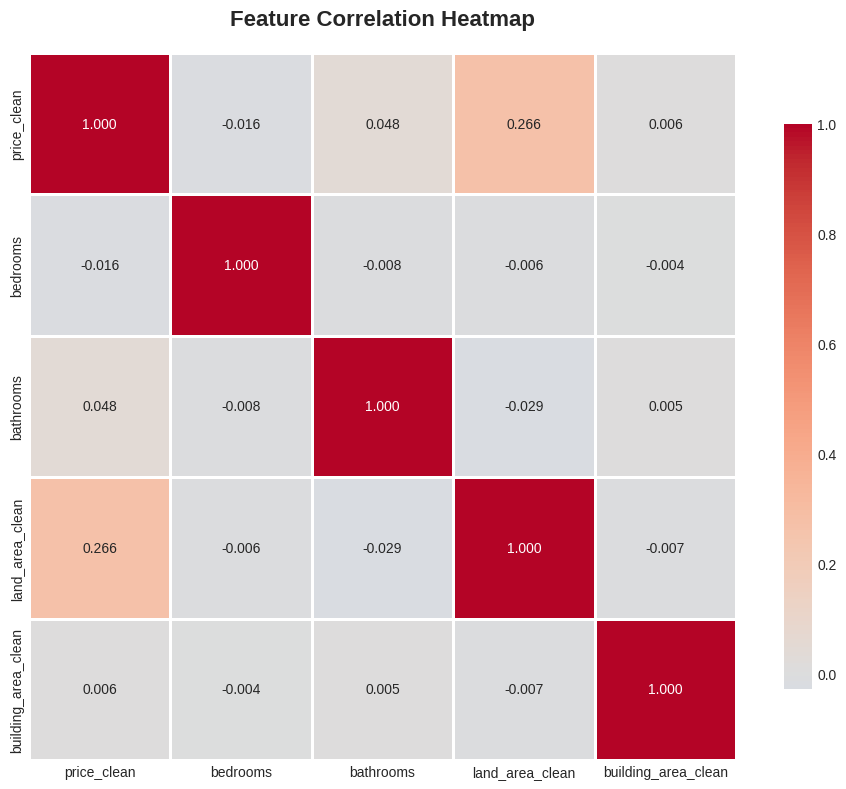


Correlation with Price:
price_clean            1.000000
land_area_clean        0.265516
bathrooms              0.047529
building_area_clean    0.006318
bedrooms              -0.016292
Name: price_clean, dtype: float64


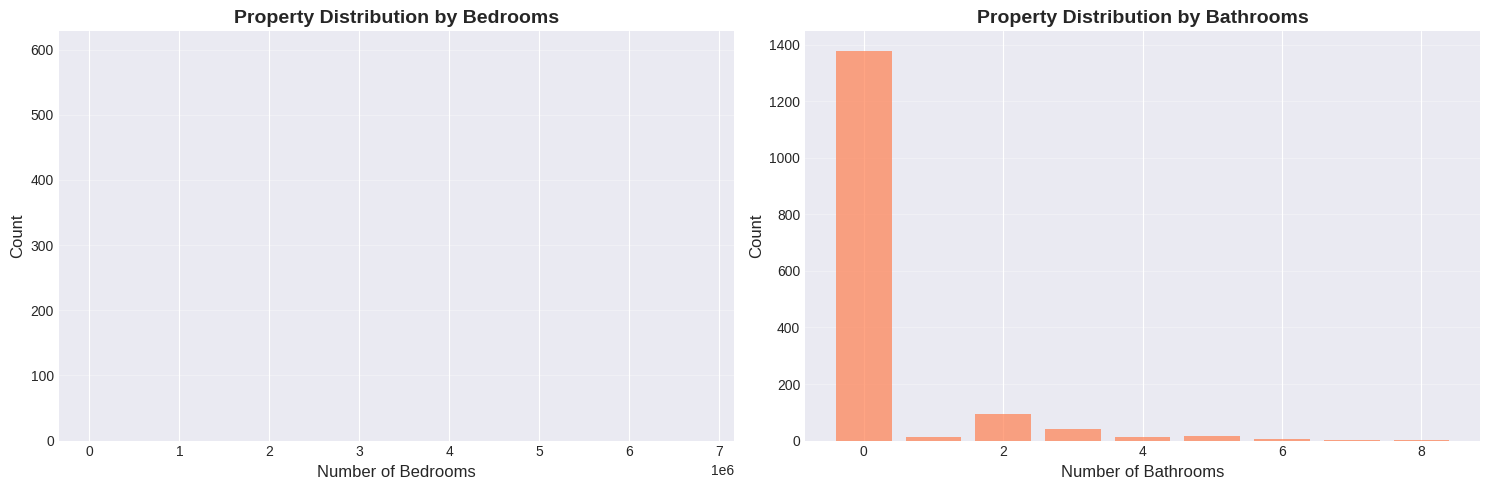

In [7]:

# Top locations by count and average price
location_stats = df.groupby('location').agg({
    'price_clean': ['count', 'mean', 'median']
}).round(2)
location_stats.columns = ['Count', 'Mean Price', 'Median Price']
location_stats = location_stats.sort_values('Count', ascending=False).head(15)

fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=('Top 15 Locations by Count', 'Top 15 Locations by Average Price')
)

# Count chart
fig.add_trace(
    go.Bar(x=location_stats.index, y=location_stats['Count'],
           marker_color='steelblue', name='Count'),
    row=1, col=1
)

# Average price chart
top_price_locations = df.groupby('location')['price_clean'].mean().sort_values(ascending=False).head(15)
fig.add_trace(
    go.Bar(x=top_price_locations.index, y=top_price_locations.values,
           marker_color='coral', name='Avg Price'),
    row=1, col=2
)

fig.update_xaxes(tickangle=45)
fig.update_layout(height=500, showlegend=False, title_text="Location Analysis")
fig.show()

print("\nTop 10 Most Expensive Locations:")
print(top_price_locations.head(10))

# Correlation heatmap
correlation_features = ['price_clean', 'bedrooms', 'bathrooms', 'land_area_clean', 'building_area_clean']
correlation_matrix = df[correlation_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8}, fmt='.3f')
plt.title('Feature Correlation Heatmap', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("\nCorrelation with Price:")
print(correlation_matrix['price_clean'].sort_values(ascending=False))

# Scatter plots for size metrics vs price
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=('Land Size vs Price', 'Building Area vs Price')
)

# Land size vs price
fig.add_trace(
    go.Scatter(x=df['land_area_clean'], y=df['price_clean'],
               mode='markers', marker=dict(color='steelblue', size=5, opacity=0.6),
               name='Land Size'),
    row=1, col=1
)

# Building area vs price
fig.add_trace(
    go.Scatter(x=df['building_area_clean'], y=df['price_clean'],
               mode='markers', marker=dict(color='coral', size=5, opacity=0.6),
               name='Building Area'),
    row=1, col=2
)

fig.update_xaxes(title_text="Land Size (m²)", row=1, col=1)
fig.update_xaxes(title_text="Building Area (m²)", row=1, col=2)
fig.update_yaxes(title_text="Price (USD)", row=1, col=1)
fig.update_yaxes(title_text="Price (USD)", row=1, col=2)
fig.update_layout(height=500, showlegend=False, title_text="Size Metrics vs Price")
fig.show()

# Bedrooms and bathrooms distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Bedrooms distribution
bedroom_counts = df['bedrooms'].value_counts().sort_index()
axes[0].bar(bedroom_counts.index, bedroom_counts.values, color='steelblue', alpha=0.7)
axes[0].set_xlabel('Number of Bedrooms', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].set_title('Property Distribution by Bedrooms', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Bathrooms distribution
bathroom_counts = df['bathrooms'].value_counts().sort_index()
axes[1].bar(bathroom_counts.index, bathroom_counts.values, color='coral', alpha=0.7)
axes[1].set_xlabel('Number of Bathrooms', fontsize=12)
axes[1].set_ylabel('Count', fontsize=12)
axes[1].set_title('Property Distribution by Bathrooms', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [8]:
# Create a clean dataset for modeling
df_model = df.copy()

# Remove rows with missing price (target variable)
df_model = df_model[df_model['price_clean'].notna()]

# Remove extreme outliers using IQR method for price
# Using a multiplier of 3 for IQR is common, but can be adjusted. Let's try 2 for slightly stricter removal
Q1 = df_model['price_clean'].quantile(0.25)
Q3 = df_model['price_clean'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 2 * IQR # Adjusted multiplier
upper_bound = Q3 + 2 * IQR # Adjusted multiplier

# Apply outlier removal
df_model = df_model[(df_model['price_clean'] >= lower_bound) & (df_model['price_clean'] <= upper_bound)]

print(f"Dataset after cleaning: {len(df_model)} properties")
print(f"Removed {len(df) - len(df_model)} outliers/invalid records")

Dataset after cleaning: 1441 properties
Removed 123 outliers/invalid records


In [9]:
# Feature Engineering (Numerical and Categorical)"""

# Create new features with improved error handling

# 1. Price per square meter (building) - Handle potential division by zero or null
df_model['price_per_sqm_building'] = np.where(
    (df_model['building_area_clean'].notna()) & (df_model['building_area_clean'] > 0),
    df_model['price_clean'] / df_model['building_area_clean'],
    np.nan
)

# 2. Price per square meter (land) - Handle potential division by zero or null
df_model['price_per_sqm_land'] = np.where(
    (df_model['land_area_clean'].notna()) & (df_model['land_area_clean'] > 0),
    df_model['price_clean'] / df_model['land_area_clean'],
    np.nan
)

# 3. Building to land ratio - Handle potential division by zero or null
df_model['building_land_ratio'] = np.where(
    (df_model['land_area_clean'].notna()) & (df_model['land_area_clean'] > 0),
    df_model['building_area_clean'] / df_model['land_area_clean'],
    np.nan
)

# 4. Total rooms (handle potential NaNs in original columns before adding)
df_model['total_rooms'] = df_model['bedrooms'].fillna(0) + df_model['bathrooms'].fillna(0)

# 5. Bathroom to bedroom ratio (handle potential division by zero or null in bedrooms)
df_model['bath_bed_ratio'] = np.where(
    (df_model['bedrooms'].notna()) & (df_model['bedrooms'] > 0),
    df_model['bathrooms'] / df_model['bedrooms'],
    np.nan
)

# 6. Extract location type (suburb classification) - Ensure it handles None/NaN gracefully
def classify_location(location):
    if pd.isna(location):
        return 'Unknown'
    location_lower = str(location).lower()
    if 'high-density' in location_lower or 'high density' in location_lower:
        return 'High-Density'
    elif 'cbd' in location_lower or 'city centre' in location_lower or 'central business district' in location_lower:
        return 'CBD'
    elif any(suburb in location_lower for suburb in ['borrowdale', 'glen lorne', 'highlands', 'hogerty', 'greendale', 'mount pleasant', 'avondale', 'ballantyne park']):
        return 'Premium'
    elif any(area in location_lower for area in ['industrial', 'factory', 'commercial']):
        return 'Industrial'
    elif any(area in location_lower for area in ['rural', 'farm', 'plot']):
        return 'Rural'
    else:
        return 'Standard'

df_model['location_type'] = df_model['location'].apply(classify_location)

# 7. Extract city from location - Ensure it handles None/NaN gracefully
def extract_city(location):
    if pd.isna(location):
        return 'Unknown'
    location_str = str(location)
    city_keywords = {
        'Harare': ['harare'],
        'Bulawayo': ['bulawayo'],
        'Gweru': ['gweru'],
        'Mutare': ['mutare'],
        'Kwekwe': ['kwekwe'],
        'Masvingo': ['masvingo'],
        'Chitungwiza': ['chitungwiza'],
        'Epworth': ['epworth']
    }

    for city, keywords in city_keywords.items():
        if any(keyword in location_str.lower() for keyword in keywords):
            return city
    return 'Other'

df_model['city'] = df_model['location'].apply(extract_city)

# 8. Interaction features
df_model['premium_location_building_area'] = df_model['building_area_clean'] * (df_model['location_type'] == 'Premium').astype(int)
df_model['cbd_location_building_area'] = df_model['building_area_clean'] * (df_model['location_type'] == 'CBD').astype(int)

# 9. Property age feature (if year_built exists in dataset)
if 'year_built' in df_model.columns:
    current_year = pd.Timestamp.now().year
    df_model['property_age'] = current_year - df_model['year_built']
    # Handle invalid years
    df_model['property_age'] = np.where(
        (df_model['property_age'] < 0) | (df_model['property_age'] > 200),
        np.nan,
        df_model['property_age']
    )

# 10. Size categories
df_model['size_category'] = pd.cut(
    df_model['building_area_clean'],
    bins=[0, 100, 200, 300, 500, np.inf],
    labels=['Very Small', 'Small', 'Medium', 'Large', 'Very Large'],
    right=False
)

print("Engineered features updated and created successfully!")
print(f"\nNew/Updated features: {['price_per_sqm_building', 'price_per_sqm_land', 'building_land_ratio', 'total_rooms', 'bath_bed_ratio', 'location_type', 'city', 'premium_location_building_area', 'cbd_location_building_area']}")

# Display feature statistics
print("\nFeature Statistics:")
feature_stats = df_model[['price_per_sqm_building', 'price_per_sqm_land', 'building_land_ratio', 'total_rooms', 'bath_bed_ratio']].describe()
print(feature_stats.round(2))

"""# Text Feature Engineering (Use of NLP techniques)"""

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import re

# Clean text data with improved cleaning
def clean_text(text):
    if pd.isna(text):
        return ''
    text = str(text).lower()
    # Remove special characters but keep basic punctuation
    text = re.sub(r'[^a-zA-Z0-9\s\.\,\!]', ' ', text)
    # Remove extra whitespace
    text = ' '.join(text.split())
    return text

# Check if 'title' column exists for description, otherwise use empty string
if 'title' in df_model.columns:
    df_model['description_clean'] = df_model['title'].apply(clean_text)
else:
    df_model['description_clean'] = ''

# Check if 'amenities' column exists. If not, create an empty one to prevent KeyError.
if 'amenities' not in df_model.columns:
    df_model['amenities'] = ''

df_model['amenities_clean'] = df_model['amenities'].apply(clean_text)

# Enhanced amenity feature extraction
def extract_amenity_features(amenities):
    if pd.isna(amenities):
        amenities = ''
    amenities_lower = str(amenities).lower()

    features = {
        'has_pool': int('pool' in amenities_lower or 'swimming' in amenities_lower),
        'has_garage': int('garage' in amenities_lower or 'carport' in amenities_lower or 'parking' in amenities_lower),
        'has_security': int('security' in amenities_lower or 'alarm' in amenities_lower or 'guard' in amenities_lower or 'fence' in amenities_lower),
        'has_garden': int('garden' in amenities_lower or 'yard' in amenities_lower or 'lawn' in amenities_lower),
        'has_fireplace': int('fireplace' in amenities_lower),
        'has_borehole': int('borehole' in amenities_lower or 'well' in amenities_lower),
        'has_solar': int('solar' in amenities_lower),
        'has_ensuite': int('en suite' in amenities_lower or 'ensuite' in amenities_lower),
        'has_kitchen': int('kitchen' in amenities_lower),
        'has_cottage': int('cottage' in amenities_lower or 'flatlet' in amenities_lower or 'granny flat' in amenities_lower),
        'has_aircon': int('air condition' in amenities_lower or 'air conditioning' in amenities_lower or 'ac' in amenities_lower),
        'has_furnished': int('furnished' in amenities_lower),
        'has_wifi': int('wifi' in amenities_lower or 'internet' in amenities_lower),
        'has_gym': int('gym' in amenities_lower or 'fitness' in amenities_lower),
        'has_balcony': int('balcony' in amenities_lower or 'patio' in amenities_lower or 'terrace' in amenities_lower)
    }
    return pd.Series(features)

amenity_features = df_model['amenities'].apply(extract_amenity_features)
df_model = pd.concat([df_model, amenity_features], axis=1)

# TF-IDF for description with improved parameters
try:
    # Filter out very short descriptions
    desc_lengths = df_model['description_clean'].str.len()
    valid_descriptions = desc_lengths > 10

    # Ensure there are valid descriptions to fit the TFIDF model
    if valid_descriptions.sum() > 0:
        tfidf_desc = TfidfVectorizer(
            max_features=100,
            stop_words='english',
            min_df=2,
            max_df=0.8,
            ngram_range=(1, 2)  # Include bigrams
        )
        tfidf_matrix_desc = tfidf_desc.fit_transform(df_model.loc[valid_descriptions, 'description_clean'])

        # Create feature names
        feature_names = tfidf_desc.get_feature_names_out()
        tfidf_df_desc = pd.DataFrame(
            tfidf_matrix_desc.toarray(),
            columns=[f'desc_tfidf_{name}' for name in feature_names],
            index=df_model.loc[valid_descriptions].index
        )

        # Merge back with original dataframe, filling missing values with 0
        df_model = df_model.merge(tfidf_df_desc, how='left', left_index=True, right_index=True)
        # Fill any newly created TFIDF columns (for rows that had invalid descriptions) with 0
        df_model[tfidf_df_desc.columns] = df_model[tfidf_df_desc.columns].fillna(0)

        print(f"TF-IDF features created: {len(feature_names)}")
    else:
        print("No valid descriptions to create TF-IDF features.")
        # Create dummy TF-IDF columns if no valid descriptions exist, to maintain structure
        for i in range(50): # arbitrary number of dummy features
            df_model[f'desc_tfidf_{i}'] = 0

except Exception as e:
    print(f"Error in TF-IDF processing: {e}")
    # Create dummy TF-IDF columns if processing fails
    for i in range(50):
        df_model[f'desc_tfidf_{i}'] = 0

# Additional text features - description length and word count
df_model['description_length'] = df_model['description_clean'].str.len()
df_model['description_word_count'] = df_model['description_clean'].str.split().str.len()

# Fill NaN values for new text features
df_model['description_length'] = df_model['description_length'].fillna(0)
df_model['description_word_count'] = df_model['description_word_count'].fillna(0)

print("Text feature engineering completed!")
print(f"Amenity features extracted: {list(amenity_features.columns)}")
print(f"Description length statistics:")
print(f"  Mean: {df_model['description_length'].mean():.2f}")
print(f"  Max: {df_model['description_length'].max()}")
print(f"  Min: {df_model['description_length'].min()}")

# Display summary of amenity features
amenity_summary = df_model[list(amenity_features.columns)].sum().sort_values(ascending=False)
print("\nMost common amenities:")
for amenity, count in amenity_summary.head(10).items():
    print(f"  {amenity}: {count} properties ({count/len(df_model)*100:.1f}%) aliquot.")

Engineered features updated and created successfully!

New/Updated features: ['price_per_sqm_building', 'price_per_sqm_land', 'building_land_ratio', 'total_rooms', 'bath_bed_ratio', 'location_type', 'city', 'premium_location_building_area', 'cbd_location_building_area']

Feature Statistics:
       price_per_sqm_building  price_per_sqm_land  building_land_ratio  \
count                 1048.00             1370.00              1370.00   
mean                  9425.08             1595.15                10.78   
std                  56868.51            20134.52               217.50   
min                      0.02                0.00                 0.00   
25%                    191.67               43.50                 0.00   
50%                    500.00               95.47                 0.22   
75%                   1100.00              200.00                 0.67   
max                 680000.00           600000.00              8000.00   

       total_rooms  bath_bed_ratio  
coun

In [10]:
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import os
import cv2
images_folder = "/content/drive/MyDrive/images 1"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
# Encoding Categorical features"""

from sklearn.preprocessing import LabelEncoder
import pandas as pd # Ensure pandas is imported for pd.api.types

# 2) CATEGORICAL ENCODING
# =========================================================

le_location = LabelEncoder()
le_location_type = LabelEncoder()
le_city = LabelEncoder()
# le_agent = LabelEncoder() # Removed as 'agent_name' column does not exist

# Fill NaNs before encoding and then encode
df_model['location_encoded'] = le_location.fit_transform(df_model['location'].fillna('Unknown'))
df_model['location_type_encoded'] = le_location_type.fit_transform(df_model['location_type'].fillna('Unknown'))
df_model['city_encoded'] = le_city.fit_transform(df_model['city'].fillna('Unknown'))
# df_model['agent_encoded'] = le_agent.fit_transform(df_model['agent_name'].fillna('Unknown')) # Removed

print("Categorical encoding completed!")
print(f"Unique locations: {len(le_location.classes_)}")
print(f"Unique cities: {len(le_city.classes_)}")
# print(f"Unique agents: {len(le_agent.classes_)}") # Removed

# =========================================================
# 3) FEATURE SELECTION & CLEANING
# =========================================================

feature_columns = [
    # Basic numeric features
    'bedrooms', 'bathrooms', 'land_area_clean', 'building_area_clean',

    # Engineered numeric features (must already exist)
    'price_per_sqm_building', 'price_per_sqm_land', 'building_land_ratio',
    'total_rooms', 'bath_bed_ratio',

    # Encoded categorical
    'location_encoded', 'location_type_encoded', 'city_encoded', # 'agent_encoded' removed

    # Amenity binary features
    'has_pool', 'has_garage', 'has_security', 'has_garden', 'has_fireplace',
    'has_borehole', 'has_solar', 'has_ensuite', 'has_kitchen', 'has_cottage',
]

# Add TF-IDF features
tfidf_cols = [col for col in df_model.columns if col.startswith('desc_tfidf_')]
feature_columns.extend(tfidf_cols)

# Handle missing values in feature columns
for col in feature_columns:
    # Use pd.api.types.is_numeric_dtype for robust type checking
    if pd.api.types.is_numeric_dtype(df_model[col]):
        df_model[col] = df_model[col].fillna(df_model[col].median())
    else:
        df_model[col] = df_model[col].fillna(0)

# Replace infinite values with NaN then fill again
df_model = df_model.replace([np.inf, -np.inf], np.nan)
for col in feature_columns:
    if pd.api.types.is_numeric_dtype(df_model[col]):
        df_model[col] = df_model[col].fillna(df_model[col].median())

# =========================================================
# 4) BUILD X, y
# =========================================================

X = df_model[feature_columns].values
y = df_model['price_clean'].values  # make sure price_clean exists & numeric

print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")
print(f"\nTotal features: {len(feature_columns)}")
print(f"Total samples: {len(X)}")

Categorical encoding completed!
Unique locations: 29
Unique cities: 3
Feature matrix shape: (1441, 122)
Target vector shape: (1441,)

Total features: 122
Total samples: 1441


### Prepare Image Data for CNN

In [12]:
from tqdm import tqdm

image_size = (128, 128) # Define a standard size for images

loaded_images = []
valid_indices = []

# Ensure image_filenames are strings and handle potential NaNs
df_model['image_filenames'] = df_model['image_filenames'].fillna('').astype(str)

for idx, row in tqdm(df_model.iterrows(), total=len(df_model), desc="Processing Images"):
    filename = row['image_filenames']
    if filename:
        image_path = os.path.join(images_folder, filename)
        if os.path.exists(image_path):
            try:
                img = cv2.imread(image_path)
                if img is not None:
                    img = cv2.resize(img, image_size)
                    img = img / 255.0 # Normalize pixel values
                    loaded_images.append(img)
                    valid_indices.append(idx)
                else:
                    # print(f"Warning: Could not load image {image_path}")
                    pass
            except Exception as e:
                # print(f"Error loading image {image_path}: {e}")
                pass
        else:
            # print(f"Warning: Image file not found: {image_path}")
            pass

images = np.array(loaded_images)
# Convert valid_indices to a DataFrame index for .iloc later
valid_indices = pd.Index(valid_indices)

print(f"Successfully loaded {len(loaded_images)} images for {len(valid_indices)} valid properties.")
print(f"Shape of loaded images array: {images.shape}")

Processing Images: 100%|██████████| 1441/1441 [02:23<00:00, 10.06it/s]

Successfully loaded 405 images for 405 valid properties.
Shape of loaded images array: (405, 128, 128, 3)


In [13]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import time
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Prepare data for CNN models
print("Preparing data for CNN models...")

# Use only samples with valid images
df_model_valid = df_model.loc[valid_indices].copy() # Changed .iloc to .loc
X_valid = df_model_valid[feature_columns].values # Derive X_valid from the filtered DataFrame
y_valid = df_model_valid['price_clean'].values   # Derive y_valid from the filtered DataFrame

print(f"Valid samples with images: {len(df_model_valid)}")

# Split data (80% for train+val, 20% for test)
X_train_full, X_test, y_train_full, y_test, images_train_full, images_test = train_test_split(
    X_valid, y_valid, images, test_size=0.2, random_state=42
)

# Split train+val into train and validation (75% train, 25% val from train_full, effectively 60/20/20)
X_train, X_val, y_train, y_val, images_train, images_val = train_test_split(
    X_train_full, y_train_full, images_train_full, test_size=0.25, random_state=42
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Preparing data for CNN models...
Valid samples with images: 405
Training set: 243 samples
Validation set: 81 samples
Test set: 81 samples


In [14]:
## 1. AlexNet"""

def create_alexnet(input_shape_img=(224, 224, 3), input_shape_tabular=None, num_classes=1):
    # Image branch
    img_input = layers.Input(shape=input_shape_img, name='image_input')

    # Block 1
    x = layers.Conv2D(96, (11, 11), strides=4, activation='relu')(img_input)
    x = layers.MaxPooling2D((3, 3), strides=2)(x)
    x = layers.BatchNormalization()(x)

    # Block 2
    x = layers.Conv2D(256, (5, 5), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D((3, 3), strides=2)(x)
    x = layers.BatchNormalization()(x)

    # Block 3
    x = layers.Conv2D(384, (3, 3), padding='same', activation='relu')(x)

    # Block 4
    x = layers.Conv2D(384, (3, 3), padding='same', activation='relu')(x)

    # Block 5
    x = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D((3, 3), strides=2)(x)

    # Flatten
    x = layers.Flatten()(x)
    x = layers.Dense(4096, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(4096, activation='relu')(x)
    x = layers.Dropout(0.5)(x)

    img_features = layers.Dense(256, activation='relu', name='img_features')(x)

    # Tabular branch
    if input_shape_tabular is not None:
        tab_input = layers.Input(shape=(input_shape_tabular,), name='tabular_input')
        tab_x = layers.Dense(128, activation='relu')(tab_input)
        tab_x = layers.Dropout(0.3)(tab_x)
        tab_x = layers.Dense(64, activation='relu')(tab_x)
        tab_features = layers.Dense(32, activation='relu', name='tab_features')(tab_x)

        # Combine branches
        combined = layers.concatenate([img_features, tab_features])
        combined = layers.Dense(128, activation='relu')(combined)
        combined = layers.Dropout(0.3)(combined)
        outputs = layers.Dense(num_classes, activation='linear', name='output')(combined)

        model = Model(inputs=[img_input, tab_input], outputs=outputs, name='AlexNet')
    else:
        outputs = layers.Dense(num_classes, activation='linear', name='output')(img_features)
        model = Model(inputs=img_input, outputs=outputs, name='AlexNet')

    return model

## 2. NIN (Network In Network)"""

def create_nin(input_shape_img=(224, 224, 3), input_shape_tabular=None, num_classes=1):
    def mlp_conv(x, filters, kernel_size=1):
        x = layers.Conv2D(filters, kernel_size, padding='same', activation='relu')(x)
        x = layers.Conv2D(filters, 1, padding='same', activation='relu')(x)
        x = layers.Conv2D(filters, 1, padding='same', activation='relu')(x)
        return x

    # Image branch
    img_input = layers.Input(shape=input_shape_img, name='image_input')

    # Block 1
    x = mlp_conv(img_input, 192, 5)
    x = layers.MaxPooling2D((3, 3), strides=2, padding='same')(x)
    x = layers.Dropout(0.5)(x)

    # Block 2
    x = mlp_conv(x, 160, 1)
    x = mlp_conv(x, 96, 1)
    x = layers.MaxPooling2D((3, 3), strides=2, padding='same')(x)
    x = layers.Dropout(0.5)(x)

    # Block 3
    x = mlp_conv(x, 192, 1)
    x = mlp_conv(x, 192, 1)
    x = mlp_conv(x, 192, 1)
    x = layers.GlobalAveragePooling2D()(x)

    img_features = layers.Dense(256, activation='relu', name='img_features')(x)

    # Tabular branch
    if input_shape_tabular is not None:
        tab_input = layers.Input(shape=(input_shape_tabular,), name='tabular_input')
        tab_x = layers.Dense(128, activation='relu')(tab_input)
        tab_x = layers.Dropout(0.3)(tab_x)
        tab_x = layers.Dense(64, activation='relu')(tab_x)
        tab_features = layers.Dense(32, activation='relu', name='tab_features')(tab_x)

        # Combine branches
        combined = layers.concatenate([img_features, tab_features])
        combined = layers.Dense(128, activation='relu')(combined)
        combined = layers.Dropout(0.3)(combined)
        outputs = layers.Dense(num_classes, activation='linear', name='output')(combined)

        model = Model(inputs=[img_input, tab_input], outputs=outputs, name='NIN')
    else:
        outputs = layers.Dense(num_classes, activation='linear', name='output')(img_features)
        model = Model(inputs=img_input, outputs=outputs, name='NIN')

    return model
## 3. ZFNet"""

def create_zfnet(input_shape_img=(224, 224, 3), input_shape_tabular=None, num_classes=1):
    # Image branch
    img_input = layers.Input(shape=input_shape_img, name='image_input')

    # Block 1
    x = layers.Conv2D(96, (7, 7), strides=2, activation='relu')(img_input)
    x = layers.MaxPooling2D((3, 3), strides=2)(x)
    x = layers.BatchNormalization()(x)

    # Block 2
    x = layers.Conv2D(256, (5, 5), strides=2, activation='relu')(x)
    x = layers.MaxPooling2D((3, 3), strides=2)(x)
    x = layers.BatchNormalization()(x)

    # Block 3
    x = layers.Conv2D(384, (3, 3), padding='same', activation='relu')(x)

    # Block 4
    x = layers.Conv2D(384, (3, 3), padding='same', activation='relu')(x)

    # Block 5
    x = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D((3, 3), strides=2)(x)

    # Flatten
    x = layers.Flatten()(x)
    x = layers.Dense(4096, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(4096, activation='relu')(x)
    x = layers.Dropout(0.5)(x)

    img_features = layers.Dense(256, activation='relu', name='img_features')(x)

    # Tabular branch
    if input_shape_tabular is not None:
        tab_input = layers.Input(shape=(input_shape_tabular,), name='tabular_input')
        tab_x = layers.Dense(128, activation='relu')(tab_input)
        tab_x = layers.Dropout(0.3)(tab_x)
        tab_x = layers.Dense(64, activation='relu')(tab_x)
        tab_features = layers.Dense(32, activation='relu', name='tab_features')(tab_x)

        # Combine branches
        combined = layers.concatenate([img_features, tab_features])
        combined = layers.Dense(128, activation='relu')(combined)
        combined = layers.Dropout(0.3)(combined)
        outputs = layers.Dense(num_classes, activation='linear', name='output')(combined)

        model = Model(inputs=[img_input, tab_input], outputs=outputs, name='ZFNet')
    else:
        outputs = layers.Dense(num_classes, activation='linear', name='output')(img_features)
        model = Model(inputs=img_input, outputs=outputs, name='ZFNet')

    return model

## 4. VGG"""

def create_vgg16(input_shape_img=(224, 224, 3), input_shape_tabular=None, num_classes=1):
    # Image branch - VGG16 style
    img_input = layers.Input(shape=input_shape_img, name='image_input')

    # Block 1
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(img_input)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), strides=2)(x)

    # Block 2
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), strides=2)(x)

    # Block 3
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), strides=2)(x)

    # Block 4
    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), strides=2)(x)

    # Block 5
    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), strides=2)(x)

    x = layers.Flatten()(x)
    x = layers.Dense(4096, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(4096, activation='relu')(x)
    x = layers.Dropout(0.5)(x)

    img_features = layers.Dense(256, activation='relu', name='img_features')(x)

    # Tabular branch
    if input_shape_tabular is not None:
        tab_input = layers.Input(shape=(input_shape_tabular,), name='tabular_input')
        tab_x = layers.Dense(128, activation='relu')(tab_input)
        tab_x = layers.Dropout(0.3)(tab_x)
        tab_x = layers.Dense(64, activation='relu')(tab_x)
        tab_features = layers.Dense(32, activation='relu', name='tab_features')(tab_x)

        # Combine branches
        combined = layers.concatenate([img_features, tab_features])
        combined = layers.Dense(128, activation='relu')(combined)
        combined = layers.Dropout(0.3)(combined)
        outputs = layers.Dense(num_classes, activation='linear', name='output')(combined)

        model = Model(inputs=[img_input, tab_input], outputs=outputs, name='VGG16')
    else:
        outputs = layers.Dense(num_classes, activation='linear', name='output')(img_features)
        model = Model(inputs=img_input, outputs=outputs, name='VGG16')

    return model

In [15]:
## 5. GoogleNet (Inception v1)"""

def create_googlenet(input_shape_img=(224, 224, 3), input_shape_tabular=None, num_classes=1):
    def inception_module(x, filters):
        # 1x1
        conv1 = layers.Conv2D(filters[0], (1, 1), padding='same', activation='relu')(x)

        # 3x3
        conv3 = layers.Conv2D(filters[1], (1, 1), padding='same', activation='relu')(x)
        conv3 = layers.Conv2D(filters[2], (3, 3), padding='same', activation='relu')(conv3)

        # 5x5
        conv5 = layers.Conv2D(filters[3], (1, 1), padding='same', activation='relu')(x)
        conv5 = layers.Conv2D(filters[4], (5, 5), padding='same', activation='relu')(conv5)

        # 3x3 max pooling
        pool = layers.MaxPooling2D((3, 3), strides=1, padding='same')(x)
        pool = layers.Conv2D(filters[5], (1, 1), padding='same', activation='relu')(pool)

        return layers.concatenate([conv1, conv3, conv5, pool])

    # Image branch
    img_input = layers.Input(shape=input_shape_img, name='image_input')

    # Initial layers
    x = layers.Conv2D(64, (7, 7), strides=2, padding='same', activation='relu')(img_input)
    x = layers.MaxPooling2D((3, 3), strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv2D(64, (1, 1), padding='same', activation='relu')(x)
    x = layers.Conv2D(192, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((3, 3), strides=2, padding='same')(x)

    # Inception modules
    x = inception_module(x, [64, 96, 128, 16, 32, 32])  # 3a
    x = inception_module(x, [128, 128, 192, 32, 96, 64])  # 3b
    x = layers.MaxPooling2D((3, 3), strides=2, padding='same')(x)

    x = inception_module(x, [192, 96, 208, 16, 48, 64])  # 4a
    x = inception_module(x, [160, 112, 224, 24, 64, 64])  # 4b
    x = inception_module(x, [128, 128, 256, 24, 64, 64])  # 4c
    x = inception_module(x, [112, 144, 288, 32, 64, 64])  # 4d
    x = inception_module(x, [256, 160, 320, 32, 128, 128])  # 4e
    x = layers.MaxPooling2D((3, 3), strides=2, padding='same')(x)

    x = inception_module(x, [256, 160, 320, 32, 128, 128])  # 5a
    x = inception_module(x, [384, 192, 384, 48, 128, 128])  # 5b

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.4)(x)

    img_features = layers.Dense(256, activation='relu', name='img_features')(x)

    # Tabular branch
    if input_shape_tabular is not None:
        tab_input = layers.Input(shape=(input_shape_tabular,), name='tabular_input')
        tab_x = layers.Dense(128, activation='relu')(tab_input)
        tab_x = layers.Dropout(0.3)(tab_x)
        tab_x = layers.Dense(64, activation='relu')(tab_x)
        tab_features = layers.Dense(32, activation='relu', name='tab_features')(tab_x)

        # Combine branches
        combined = layers.concatenate([img_features, tab_features])
        combined = layers.Dense(128, activation='relu')(combined)
        combined = layers.Dropout(0.3)(combined)
        outputs = layers.Dense(num_classes, activation='linear', name='output')(combined)

        model = Model(inputs=[img_input, tab_input], outputs=outputs, name='GoogleNet')
    else:
        outputs = layers.Dense(num_classes, activation='linear', name='output')(img_features)
        model = Model(inputs=img_input, outputs=outputs, name='GoogleNet')

    return model

## 6. Inception v3"""

def create_inception_v3(input_shape_img=(224, 224, 3), input_shape_tabular=None, num_classes=1):
    def inception_module_a(x):
        branch1 = layers.Conv2D(64, (1, 1), padding='same', activation='relu')(x)

        branch2 = layers.Conv2D(48, (1, 1), padding='same', activation='relu')(x)
        branch2 = layers.Conv2D(64, (5, 5), padding='same', activation='relu')(branch2)

        branch3 = layers.Conv2D(64, (1, 1), padding='same', activation='relu')(x)
        branch3 = layers.Conv2D(96, (3, 3), padding='same', activation='relu')(branch3)
        branch3 = layers.Conv2D(96, (3, 3), padding='same', activation='relu')(branch3)

        branch4 = layers.AveragePooling2D((3, 3), strides=1, padding='same')(x)
        branch4 = layers.Conv2D(32, (1, 1), padding='same', activation='relu')(branch4)

        return layers.concatenate([branch1, branch2, branch3, branch4])

    # Image branch
    img_input = layers.Input(shape=input_shape_img, name='image_input')

    # Stem
    x = layers.Conv2D(32, (3, 3), strides=2, padding='valid', activation='relu')(img_input)
    x = layers.Conv2D(32, (3, 3), padding='valid', activation='relu')(x)
    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D((3, 3), strides=2)(x)

    x = layers.Conv2D(80, (1, 1), padding='same', activation='relu')(x)
    x = layers.Conv2D(192, (3, 3), padding='valid', activation='relu')(x)
    x = layers.MaxPooling2D((3, 3), strides=2)(x)

    # Inception modules
    for _ in range(3):
        x = inception_module_a(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.2)(x)

    img_features = layers.Dense(256, activation='relu', name='img_features')(x)

    # Tabular branch
    if input_shape_tabular is not None:
        tab_input = layers.Input(shape=(input_shape_tabular,), name='tabular_input')
        tab_x = layers.Dense(128, activation='relu')(tab_input)
        tab_x = layers.Dropout(0.3)(tab_x)
        tab_x = layers.Dense(64, activation='relu')(tab_x)
        tab_features = layers.Dense(32, activation='relu', name='tab_features')(tab_x)

        # Combine branches
        combined = layers.concatenate([img_features, tab_features])
        combined = layers.Dense(128, activation='relu')(combined)
        combined = layers.Dropout(0.3)(combined)
        outputs = layers.Dense(num_classes, activation='linear', name='output')(combined)

        model = Model(inputs=[img_input, tab_input], outputs=outputs, name='InceptionV3')
    else:
        outputs = layers.Dense(num_classes, activation='linear', name='output')(img_features)
        model = Model(inputs=img_input, outputs=outputs, name='InceptionV3')

    return model

## 7. Highway Network"""

def create_highway_network(input_shape_img=(224, 224, 3), input_shape_tabular=None, num_classes=1):
    class Highway(layers.Layer):
        def __init__(self, units, activation='relu', **kwargs):
            super(Highway, self).__init__(**kwargs)
            self.units = units
            self.activation = keras.activations.get(activation)

        def build(self, input_shape):
            self.dense = layers.Dense(self.units, activation=self.activation)
            self.gate = layers.Dense(self.units, activation='sigmoid')
            super(Highway, self).build(input_shape)

        def call(self, inputs):
            transformed = self.dense(inputs)
            gate = self.gate(inputs)
            return gate * transformed + (1 - gate) * inputs

    # Image branch
    img_input = layers.Input(shape=input_shape_img, name='image_input')

    # Simple CNN for images
    x = layers.Conv2D(32, (3, 3), activation='relu')(img_input)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation='relu')(x)
    x = layers.GlobalAveragePooling2D()(x)

    # Highway layers
    x = Highway(256)(x)
    x = Highway(128)(x)

    img_features = layers.Dense(64, activation='relu', name='img_features')(x)

    # Tabular branch
    if input_shape_tabular is not None:
        tab_input = layers.Input(shape=(input_shape_tabular,), name='tabular_input')
        tab_x = Highway(128)(tab_input)
        tab_x = Highway(64)(tab_x)
        tab_features = layers.Dense(32, activation='relu', name='tab_features')(tab_x)

        # Combine branches
        combined = layers.concatenate([img_features, tab_features])
        combined = Highway(64)(combined)
        outputs = layers.Dense(num_classes, activation='linear', name='output')(combined)

        model = Model(inputs=[img_input, tab_input], outputs=outputs, name='Highway')
    else:
        outputs = layers.Dense(num_classes, activation='linear', name='output')(img_features)
        model = Model(inputs=img_input, outputs=outputs, name='Highway')

    return model

## 8. Inception v4"""

def create_inception_v4(input_shape_img=(224, 224, 3), input_shape_tabular=None, num_classes=1):
    def inception_stem(x):
        # Stem implementation
        x = layers.Conv2D(32, (3, 3), strides=2, padding='valid', activation='relu')(x)
        x = layers.Conv2D(32, (3, 3), padding='valid', activation='relu')(x)
        x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)

        branch1 = layers.MaxPooling2D((3, 3), strides=2)(x)
        branch2 = layers.Conv2D(96, (3, 3), strides=2, padding='valid', activation='relu')(x)

        x = layers.concatenate([branch1, branch2])

        branch1 = layers.Conv2D(64, (1, 1), padding='same', activation='relu')(x)
        branch1 = layers.Conv2D(96, (3, 3), padding='valid', activation='relu')(branch1)

        branch2 = layers.Conv2D(64, (1, 1), padding='same', activation='relu')(x)
        branch2 = layers.Conv2D(64, (7, 1), padding='same', activation='relu')(branch2)
        branch2 = layers.Conv2D(64, (1, 7), padding='same', activation='relu')(branch2)
        branch2 = layers.Conv2D(96, (3, 3), padding='valid', activation='relu')(branch2)

        x = layers.concatenate([branch1, branch2])

        branch1 = layers.Conv2D(192, (3, 3), strides=2, padding='valid', activation='relu')(x)
        branch2 = layers.MaxPooling2D((3, 3), strides=2)(x)

        return layers.concatenate([branch1, branch2])

    def inception_a(x):
        branch1 = layers.Conv2D(96, (1, 1), padding='same', activation='relu')(x)

        branch2 = layers.Conv2D(64, (1, 1), padding='same', activation='relu')(x)
        branch2 = layers.Conv2D(96, (3, 3), padding='same', activation='relu')(branch2)

        branch3 = layers.Conv2D(64, (1, 1), padding='same', activation='relu')(x)
        branch3 = layers.Conv2D(96, (3, 3), padding='same', activation='relu')(branch3)
        branch3 = layers.Conv2D(96, (3, 3), padding='same', activation='relu')(branch3)

        branch4 = layers.AveragePooling2D((3, 3), strides=1, padding='same')(x)
        branch4 = layers.Conv2D(96, (1, 1), padding='same', activation='relu')(branch4)

        return layers.concatenate([branch1, branch2, branch3, branch4])

    # Image branch
    img_input = layers.Input(shape=input_shape_img, name='image_input')

    x = inception_stem(img_input)

    # Inception A modules
    for _ in range(4):
        x = inception_a(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.2)(x)

    img_features = layers.Dense(256, activation='relu', name='img_features')(x)

    # Tabular branch
    if input_shape_tabular is not None:
        tab_input = layers.Input(shape=(input_shape_tabular,), name='tabular_input')
        tab_x = layers.Dense(128, activation='relu')(tab_input)
        tab_x = layers.Dropout(0.3)(tab_x)
        tab_x = layers.Dense(64, activation='relu')(tab_x)
        tab_features = layers.Dense(32, activation='relu', name='tab_features')(tab_x)

        # Combine branches
        combined = layers.concatenate([img_features, tab_features])
        combined = layers.Dense(128, activation='relu')(combined)
        combined = layers.Dropout(0.3)(combined)
        outputs = layers.Dense(num_classes, activation='linear', name='output')(combined)

        model = Model(inputs=[img_input, tab_input], outputs=outputs, name='InceptionV4')
    else:
        outputs = layers.Dense(num_classes, activation='linear', name='output')(img_features)
        model = Model(inputs=img_input, outputs=outputs, name='InceptionV4')

    return model

## 9. ResNet"""

def create_resnet(input_shape_img=(224, 224, 3), input_shape_tabular=None, num_classes=1):
    def residual_block(x, filters, stride=1):
        shortcut = x

        # Main path
        x = layers.Conv2D(filters, (3, 3), strides=stride, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)

        x = layers.Conv2D(filters, (3, 3), padding='same')(x)
        x = layers.BatchNormalization()(x)

        # Shortcut path
        if stride != 1 or shortcut.shape[-1] != filters:
            shortcut = layers.Conv2D(filters, (1, 1), strides=stride)(shortcut)
            shortcut = layers.BatchNormalization()(shortcut)

        x = layers.add([x, shortcut])
        x = layers.Activation('relu')(x)
        return x

    # Image branch
    img_input = layers.Input(shape=input_shape_img, name='image_input')

    # Initial conv
    x = layers.Conv2D(64, (7, 7), strides=2, padding='same', activation='relu')(img_input)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((3, 3), strides=2, padding='same')(x)

    # Residual blocks
    x = residual_block(x, 64)
    x = residual_block(x, 64)
    x = residual_block(x, 128, stride=2)
    x = residual_block(x, 128)
    x = residual_block(x, 256, stride=2)
    x = residual_block(x, 256)
    x = residual_block(x, 512, stride=2)
    x = residual_block(x, 512)

    x = layers.GlobalAveragePooling2D()(x)

    img_features = layers.Dense(256, activation='relu', name='img_features')(x)

    # Tabular branch
    if input_shape_tabular is not None:
        tab_input = layers.Input(shape=(input_shape_tabular,), name='tabular_input')
        tab_x = layers.Dense(128, activation='relu')(tab_input)
        tab_x = layers.Dropout(0.3)(tab_x)
        tab_x = layers.Dense(64, activation='relu')(tab_x)
        tab_features = layers.Dense(32, activation='relu', name='tab_features')(tab_x)

        # Combine branches
        combined = layers.concatenate([img_features, tab_features])
        combined = layers.Dense(128, activation='relu')(combined)
        combined = layers.Dropout(0.3)(combined)
        outputs = layers.Dense(num_classes, activation='linear', name='output')(combined)

        model = Model(inputs=[img_input, tab_input], outputs=outputs, name='ResNet')
    else:
        outputs = layers.Dense(num_classes, activation='linear', name='output')(img_features)
        model = Model(inputs=img_input, outputs=outputs, name='ResNet')

    return model
## 10. Inception-ResNet-v2"""

def create_inception_resnet_v2(input_shape_img=(224, 224, 3), input_shape_tabular=None, num_classes=1):
    def inception_resnet_block(x, scale=0.1):
        branch1 = layers.Conv2D(32, (1, 1), padding='same', activation='relu')(x)

        branch2 = layers.Conv2D(32, (1, 1), padding='same', activation='relu')(x)
        branch2 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(branch2)

        branch3 = layers.Conv2D(32, (1, 1), padding='same', activation='relu')(x)
        branch3 = layers.Conv2D(48, (3, 3), padding='same', activation='relu')(branch3)
        branch3 = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(branch3)

        mixed = layers.concatenate([branch1, branch2, branch3])
        up = layers.Conv2D(x.shape[-1], (1, 1), padding='same')(mixed)

        x = layers.Lambda(lambda inputs: inputs[0] + inputs[1] * scale)([x, up])
        return x

    # Image branch
    img_input = layers.Input(shape=input_shape_img, name='image_input')

    # Stem
    x = layers.Conv2D(32, (3, 3), strides=2, padding='valid', activation='relu')(img_input)
    x = layers.Conv2D(32, (3, 3), padding='valid', activation='relu')(x)
    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D((3, 3), strides=2)(x)

    x = layers.Conv2D(80, (1, 1), padding='same', activation='relu')(x)
    x = layers.Conv2D(192, (3, 3), padding='valid', activation='relu')(x)
    x = layers.MaxPooling2D((3, 3), strides=2)(x)

    # Inception-ResNet blocks
    for _ in range(5):
        x = inception_resnet_block(x)

    x = layers.GlobalAveragePooling2D()(x)

    img_features = layers.Dense(256, activation='relu', name='img_features')(x)

    # Tabular branch
    if input_shape_tabular is not None:
        tab_input = layers.Input(shape=(input_shape_tabular,), name='tabular_input')
        tab_x = layers.Dense(128, activation='relu')(tab_input)
        tab_x = layers.Dropout(0.3)(tab_x)
        tab_x = layers.Dense(64, activation='relu')(tab_x)
        tab_features = layers.Dense(32, activation='relu', name='tab_features')(tab_x)

        # Combine branches
        combined = layers.concatenate([img_features, tab_features])
        combined = layers.Dense(128, activation='relu')(combined)
        combined = layers.Dropout(0.3)(combined)
        outputs = layers.Dense(num_classes, activation='linear', name='output')(combined)

        model = Model(inputs=[img_input, tab_input], outputs=outputs, name='InceptionResNetV2')
    else:
        outputs = layers.Dense(num_classes, activation='linear', name='output')(img_features)
        model = Model(inputs=img_input, outputs=outputs, name='InceptionResNetV2')

    return model

## 11. FractalNet"""

def create_fractalnet(input_shape_img=(224, 224, 3), input_shape_tabular=None, num_classes=1):
    def fractal_block(x, filters, depth):
        if depth == 1:
            return layers.Conv2D(filters, (3, 3), padding='same', activation='relu')(x)
        else:
            left = fractal_block(x, filters, depth-1)
            right = fractal_block(x, filters, depth-1)
            return layers.add([left, right])

    # Image branch
    img_input = layers.Input(shape=input_shape_img, name='image_input')

    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(img_input)
    x = layers.MaxPooling2D((2, 2))(x)

    # Fractal blocks
    x = fractal_block(x, 128, 3)
    x = layers.MaxPooling2D((2, 2))(x)

    x = fractal_block(x, 256, 3)
    x = layers.MaxPooling2D((2, 2))(x)

    x = fractal_block(x, 512, 3)
    x = layers.GlobalAveragePooling2D()(x)

    img_features = layers.Dense(256, activation='relu', name='img_features')(x)

    # Tabular branch
    if input_shape_tabular is not None:
        tab_input = layers.Input(shape=(input_shape_tabular,), name='tabular_input')
        tab_x = layers.Dense(128, activation='relu')(tab_input)
        tab_x = layers.Dropout(0.3)(tab_x)
        tab_x = layers.Dense(64, activation='relu')(tab_x)
        tab_features = layers.Dense(32, activation='relu', name='tab_features')(tab_x)

        # Combine branches
        combined = layers.concatenate([img_features, tab_features])
        combined = layers.Dense(128, activation='relu')(combined)
        combined = layers.Dropout(0.3)(combined)
        outputs = layers.Dense(num_classes, activation='linear', name='output')(combined)

        model = Model(inputs=[img_input, tab_input], outputs=outputs, name='FractalNet')
    else:
        outputs = layers.Dense(num_classes, activation='linear', name='output')(img_features)
        model = Model(inputs=img_input, outputs=outputs, name='FractalNet')

    return model

## 12. WideResNet"""

def create_wideresnet(input_shape_img=(224, 224, 3), input_shape_tabular=None, num_classes=1):
    def wide_residual_block(x, filters, stride=1, dropout_rate=0.3):
        shortcut = x

        # Main path
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
        x = layers.Conv2D(filters, (3, 3), strides=stride, padding='same')(x)

        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
        x = layers.Dropout(dropout_rate)(x)
        x = layers.Conv2D(filters, (3, 3), padding='same')(x)

        # Shortcut path
        if stride != 1 or shortcut.shape[-1] != filters:
            shortcut = layers.Conv2D(filters, (1, 1), strides=stride)(shortcut)

        return layers.add([x, shortcut])

    # Image branch
    img_input = layers.Input(shape=input_shape_img, name='image_input')

    # Initial conv
    x = layers.Conv2D(16, (3, 3), padding='same')(img_input)

    # Wide residual blocks
    x = wide_residual_block(x, 16 * 4)  # k=4 widening factor
    x = wide_residual_block(x, 16 * 4)

    x = wide_residual_block(x, 32 * 4, stride=2)
    x = wide_residual_block(x, 32 * 4)

    x = wide_residual_block(x, 64 * 4, stride=2)
    x = wide_residual_block(x, 64 * 4)

    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.GlobalAveragePooling2D()(x)

    img_features = layers.Dense(256, activation='relu', name='img_features')(x)

    # Tabular branch
    if input_shape_tabular is not None:
        tab_input = layers.Input(shape=(input_shape_tabular,), name='tabular_input')
        tab_x = layers.Dense(128, activation='relu')(tab_input)
        tab_x = layers.Dropout(0.3)(tab_x)
        tab_x = layers.Dense(64, activation='relu')(tab_x)
        tab_features = layers.Dense(32, activation='relu', name='tab_features')(tab_x)

        # Combine branches
        combined = layers.concatenate([img_features, tab_features])
        combined = layers.Dense(128, activation='relu')(combined)
        combined = layers.Dropout(0.3)(combined)
        outputs = layers.Dense(num_classes, activation='linear', name='output')(combined)

        model = Model(inputs=[img_input, tab_input], outputs=outputs, name='WideResNet')
    else:
        outputs = layers.Dense(num_classes, activation='linear', name='output')(img_features)
        model = Model(inputs=img_input, outputs=outputs, name='WideResNet')

    return model

## 13. Xception"""

def create_xception(input_shape_img=(224, 224, 3), input_shape_tabular=None, num_classes=1):
    # Image branch
    img_input = layers.Input(shape=input_shape_img, name='image_input')

    # Entry flow
    x = layers.Conv2D(32, (3, 3), strides=2, padding='same', activation='relu')(img_input)
    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)

    # Middle flow - simplified
    for _ in range(4):
        shortcut = x

        # Depthwise separable conv
        x = layers.DepthwiseConv2D((3, 3), padding='same', activation='relu')(x)
        x = layers.Conv2D(128, (1, 1), padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)

        x = layers.DepthwiseConv2D((3, 3), padding='same', activation='relu')(x)
        x = layers.Conv2D(128, (1, 1), padding='same')(x)
        x = layers.BatchNormalization()(x)

        x = layers.add([x, shortcut])

    # Exit flow
    x = layers.DepthwiseConv2D((3, 3), strides=2, padding='same', activation='relu')(x)
    x = layers.Conv2D(256, (1, 1), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.GlobalAveragePooling2D()(x)

    img_features = layers.Dense(256, activation='relu', name='img_features')(x)

    # Tabular branch
    if input_shape_tabular is not None:
        tab_input = layers.Input(shape=(input_shape_tabular,), name='tabular_input')
        tab_x = layers.Dense(128, activation='relu')(tab_input)
        tab_x = layers.Dropout(0.3)(tab_x)
        tab_x = layers.Dense(64, activation='relu')(tab_x)
        tab_features = layers.Dense(32, activation='relu', name='tab_features')(tab_x)

        # Combine branches
        combined = layers.concatenate([img_features, tab_features])
        combined = layers.Dense(128, activation='relu')(combined)
        combined = layers.Dropout(0.3)(combined)
        outputs = layers.Dense(num_classes, activation='linear', name='output')(combined)

        model = Model(inputs=[img_input, tab_input], outputs=outputs, name='Xception')
    else:
        outputs = layers.Dense(num_classes, activation='linear', name='output')(img_features)
        model = Model(inputs=img_input, outputs=outputs, name='Xception')

    return model

## 14. Residual Attention Network"""

def create_residual_attention(input_shape_img=(224, 224, 3), input_shape_tabular=None, num_classes=1):
    def attention_block(x, filters):
        # Trunk branch
        trunk = layers.Conv2D(filters, (1, 1), padding='same', activation='relu')(x)
        trunk = layers.Conv2D(filters, (3, 3), padding='same', activation='relu')(trunk)

        # Soft mask branch
        mask = layers.MaxPooling2D((2, 2))(x)
        mask = layers.Conv2D(filters//2, (1, 1), padding='same', activation='relu')(mask)
        mask = layers.Conv2D(filters//2, (3, 3), padding='same', activation='relu')(mask)
        mask = layers.UpSampling2D((2, 2))(mask)
        mask = layers.Conv2D(filters, (1, 1), padding='same', activation='sigmoid')(mask)

        # Apply attention
        attended = layers.multiply([trunk, mask])

        # Residual connection
        if x.shape[-1] != filters:
            x = layers.Conv2D(filters, (1, 1), padding='same')(x)

        return layers.add([x, attended])

    # Image branch
    img_input = layers.Input(shape=input_shape_img, name='image_input')

    x = layers.Conv2D(64, (7, 7), strides=2, padding='same', activation='relu')(img_input)
    x = layers.MaxPooling2D((3, 3), strides=2, padding='same')(x)

    # Attention blocks
    x = attention_block(x, 128)
    x = layers.MaxPooling2D((2, 2))(x)

    x = attention_block(x, 256)
    x = layers.MaxPooling2D((2, 2))(x)

    x = attention_block(x, 512)
    x = layers.GlobalAveragePooling2D()(x)

    img_features = layers.Dense(256, activation='relu', name='img_features')(x)

    # Tabular branch
    if input_shape_tabular is not None:
        tab_input = layers.Input(shape=(input_shape_tabular,), name='tabular_input')
        tab_x = layers.Dense(128, activation='relu')(tab_input)
        tab_x = layers.Dropout(0.3)(tab_x)
        tab_x = layers.Dense(64, activation='relu')(tab_x)
        tab_features = layers.Dense(32, activation='relu', name='tab_features')(tab_x)

        # Combine branches
        combined = layers.concatenate([img_features, tab_features])
        combined = layers.Dense(128, activation='relu')(combined)
        combined = layers.Dropout(0.3)(combined)
        outputs = layers.Dense(num_classes, activation='linear', name='output')(combined)

        model = Model(inputs=[img_input, tab_input], outputs=outputs, name='ResidualAttention')
    else:
        outputs = layers.Dense(num_classes, activation='linear', name='output')(img_features)
        model = Model(inputs=img_input, outputs=outputs, name='ResidualAttention')

    return model

In [16]:
## 15. Squeeze-and-Excitation Networks"""

def create_senet(input_shape_img=(224, 224, 3), input_shape_tabular=None, num_classes=1):
    def se_block(x, ratio=16):
        channels = x.shape[-1]

        # Squeeze
        squeeze = layers.GlobalAveragePooling2D()(x)

        # Excitation
        excitation = layers.Dense(channels // ratio, activation='relu')(squeeze)
        excitation = layers.Dense(channels, activation='sigmoid')(excitation)

        # Scale
        excitation = layers.Reshape((1, 1, channels))(excitation)
        return layers.multiply([x, excitation])

    # Image branch
    img_input = layers.Input(shape=input_shape_img, name='image_input')

    # Initial conv
    x = layers.Conv2D(64, (7, 7), strides=2, padding='same', activation='relu')(img_input)
    x = layers.MaxPooling2D((3, 3), strides=2, padding='same')(x)

    # SE-ResNet blocks
    def se_residual_block(x, filters, stride=1):
        shortcut = x

        # Main path
        x = layers.Conv2D(filters, (3, 3), strides=stride, padding='same', activation='relu')(x)
        x = layers.Conv2D(filters, (3, 3), padding='same', activation='relu')(x)
        x = se_block(x)

        # Shortcut path
        if stride != 1 or shortcut.shape[-1] != filters:
            shortcut = layers.Conv2D(filters, (1, 1), strides=stride)(shortcut)

        return layers.add([x, shortcut])

    x = se_residual_block(x, 64)
    x = se_residual_block(x, 64)
    x = se_residual_block(x, 128, stride=2)
    x = se_residual_block(x, 128)
    x = se_residual_block(x, 256, stride=2)
    x = se_residual_block(x, 256)

    x = layers.GlobalAveragePooling2D()(x)

    img_features = layers.Dense(256, activation='relu', name='img_features')(x)

    # Tabular branch
    if input_shape_tabular is not None:
        tab_input = layers.Input(shape=(input_shape_tabular,), name='tabular_input')
        tab_x = layers.Dense(128, activation='relu')(tab_input)
        tab_x = layers.Dropout(0.3)(tab_x)
        tab_x = layers.Dense(64, activation='relu')(tab_x)
        tab_features = layers.Dense(32, activation='relu', name='tab_features')(tab_x)

        # Combine branches
        combined = layers.concatenate([img_features, tab_features])
        combined = layers.Dense(128, activation='relu')(combined)
        combined = layers.Dropout(0.3)(combined)
        outputs = layers.Dense(num_classes, activation='linear', name='output')(combined)

        model = Model(inputs=[img_input, tab_input], outputs=outputs, name='SENet')
    else:
        outputs = layers.Dense(num_classes, activation='linear', name='output')(img_features)
        model = Model(inputs=img_input, outputs=outputs, name='SENet')

    return model

## 16. DenseNet"""

def create_densenet(input_shape_img=(224, 224, 3), input_shape_tabular=None, num_classes=1):
    def dense_block(x, blocks):
        for _ in range(blocks):
            # Each layer in dense block
            shortcut = x
            x = layers.BatchNormalization()(x)
            x = layers.Activation('relu')(x)
            x = layers.Conv2D(32, (3, 3), padding='same')(x)  # growth rate=32
            x = layers.Dropout(0.2)(x)
            x = layers.concatenate([shortcut, x])
        return x

    def transition_block(x, reduction=0.5):
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
        x = layers.Conv2D(int(x.shape[-1] * reduction), (1, 1), padding='same')(x)
        x = layers.AveragePooling2D((2, 2), strides=2)(x)
        return x

    # Image branch
    img_input = layers.Input(shape=input_shape_img, name='image_input')

    # Initial conv
    x = layers.Conv2D(64, (7, 7), strides=2, padding='same', activation='relu')(img_input)
    x = layers.MaxPooling2D((3, 3), strides=2, padding='same')(x)

    # Dense blocks
    x = dense_block(x, 6)  # 6 layers
    x = transition_block(x)

    x = dense_block(x, 12)  # 12 layers
    x = transition_block(x)

    x = dense_block(x, 24)  # 24 layers
    x = transition_block(x)

    x = dense_block(x, 16)  # 16 layers

    x = layers.GlobalAveragePooling2D()(x)

    img_features = layers.Dense(256, activation='relu', name='img_features')(x)

    # Tabular branch
    if input_shape_tabular is not None:
        tab_input = layers.Input(shape=(input_shape_tabular,), name='tabular_input')
        tab_x = layers.Dense(128, activation='relu')(tab_input)
        tab_x = layers.Dropout(0.3)(tab_x)
        tab_x = layers.Dense(64, activation='relu')(tab_x)
        tab_features = layers.Dense(32, activation='relu', name='tab_features')(tab_x)

        # Combine branches
        combined = layers.concatenate([img_features, tab_features])
        combined = layers.Dense(128, activation='relu')(combined)
        combined = layers.Dropout(0.3)(combined)
        outputs = layers.Dense(num_classes, activation='linear', name='output')(combined)

        model = Model(inputs=[img_input, tab_input], outputs=outputs, name='DenseNet')
    else:
        outputs = layers.Dense(num_classes, activation='linear', name='output')(img_features)
        model = Model(inputs=img_input, outputs=outputs, name='DenseNet')

    return model

## 17. Competitive Squeeze and Excitation Network"""

def create_competitive_se(input_shape_img=(224, 224, 3), input_shape_tabular=None, num_classes=1):
    def competitive_se_block(x):
        channels = x.shape[-1]

        # Global context
        gc = layers.GlobalAveragePooling2D()(x)
        gc = layers.Dense(channels // 16, activation='relu')(gc)
        gc = layers.Dense(channels, activation='sigmoid')(gc)
        gc = layers.Reshape((1, 1, channels))(gc)

        # Local context
        lc = layers.Conv2D(1, (1, 1), activation='sigmoid')(x)

        # Combine global and local context
        attention = layers.add([gc, lc])
        attention = layers.Activation('sigmoid')(attention)

        return layers.multiply([x, attention])

    # Image branch
    img_input = layers.Input(shape=input_shape_img, name='image_input')

    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(img_input)
    x = competitive_se_block(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = competitive_se_block(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = competitive_se_block(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(512, (3, 3), padding='same', activation='relu')(x)
    x = competitive_se_block(x)
    x = layers.GlobalAveragePooling2D()(x)

    img_features = layers.Dense(256, activation='relu', name='img_features')(x)

    # Tabular branch
    if input_shape_tabular is not None:
        tab_input = layers.Input(shape=(input_shape_tabular,), name='tabular_input')
        tab_x = layers.Dense(128, activation='relu')(tab_input)
        tab_x = layers.Dropout(0.3)(tab_x)
        tab_x = layers.Dense(64, activation='relu')(tab_x)
        tab_features = layers.Dense(32, activation='relu', name='tab_features')(tab_x)

        # Combine branches
        combined = layers.concatenate([img_features, tab_features])
        combined = layers.Dense(128, activation='relu')(combined)
        combined = layers.Dropout(0.3)(combined)
        outputs = layers.Dense(num_classes, activation='linear', name='output')(combined)

        model = Model(inputs=[img_input, tab_input], outputs=outputs, name='CompetitiveSE')
    else:
        outputs = layers.Dense(num_classes, activation='linear', name='output')(img_features)
        model = Model(inputs=img_input, outputs=outputs, name='CompetitiveSE')

    return model

## 18. MobileNet-v2"""

def create_mobilenet_v2(input_shape_img=(224, 224, 3), input_shape_tabular=None, num_classes=1):
    def inverted_residual_block(x, filters, stride, expansion=6):
        shortcut = x
        in_channels = x.shape[-1]

        # Expansion
        x = layers.Conv2D(in_channels * expansion, (1, 1), padding='same', activation='relu')(x)

        # Depthwise
        x = layers.DepthwiseConv2D((3, 3), strides=stride, padding='same', activation='relu')(x)

        # Projection
        x = layers.Conv2D(filters, (1, 1), padding='same')(x)

        # Residual connection
        if stride == 1 and in_channels == filters:
            x = layers.add([x, shortcut])

        return x

    # Image branch
    img_input = layers.Input(shape=input_shape_img, name='image_input')

    # Initial conv
    x = layers.Conv2D(32, (3, 3), strides=2, padding='same', activation='relu')(img_input)

    # Inverted residual blocks
    x = inverted_residual_block(x, 16, stride=1, expansion=1)

    x = inverted_residual_block(x, 24, stride=2)
    x = inverted_residual_block(x, 24, stride=1)

    x = inverted_residual_block(x, 32, stride=2)
    x = inverted_residual_block(x, 32, stride=1)
    x = inverted_residual_block(x, 32, stride=1)

    x = inverted_residual_block(x, 64, stride=2)
    x = inverted_residual_block(x, 64, stride=1)
    x = inverted_residual_block(x, 64, stride=1)
    x = inverted_residual_block(x, 64, stride=1)

    x = inverted_residual_block(x, 96, stride=1)
    x = inverted_residual_block(x, 96, stride=1)
    x = inverted_residual_block(x, 96, stride=1)

    x = inverted_residual_block(x, 160, stride=2)
    x = inverted_residual_block(x, 160, stride=1)
    x = inverted_residual_block(x, 160, stride=1)

    x = inverted_residual_block(x, 320, stride=1)

    x = layers.Conv2D(1280, (1, 1), padding='same', activation='relu')(x)
    x = layers.GlobalAveragePooling2D()(x)

    img_features = layers.Dense(256, activation='relu', name='img_features')(x)

    # Tabular branch
    if input_shape_tabular is not None:
        tab_input = layers.Input(shape=(input_shape_tabular,), name='tabular_input')
        tab_x = layers.Dense(128, activation='relu')(tab_input)
        tab_x = layers.Dropout(0.3)(tab_x)
        tab_x = layers.Dense(64, activation='relu')(tab_x)
        tab_features = layers.Dense(32, activation='relu', name='tab_features')(tab_x)

        # Combine branches
        combined = layers.concatenate([img_features, tab_features])
        combined = layers.Dense(128, activation='relu')(combined)
        combined = layers.Dropout(0.3)(combined)
        outputs = layers.Dense(num_classes, activation='linear', name='output')(combined)

        model = Model(inputs=[img_input, tab_input], outputs=outputs, name='MobileNetV2')
    else:
        outputs = layers.Dense(num_classes, activation='linear', name='output')(img_features)
        model = Model(inputs=img_input, outputs=outputs, name='MobileNetV2')

    return model

## 19. CapsuleNet"""

def create_capsulenet(input_shape_img=(224, 224, 3), input_shape_tabular=None, num_classes=1):
    class Capsule(layers.Layer):
        def __init__(self, num_capsules, dim_capsules, routings=3, **kwargs):
            super(Capsule, self).__init__(**kwargs)
            self.num_capsules = num_capsules
            self.dim_capsules = dim_capsules
            self.routings = routings

        def build(self, input_shape):
            self.input_num_capsules = input_shape[1]
            self.input_dim_capsules = input_shape[2]

            self.W = self.add_weight(
                shape=[self.num_capsules, self.input_num_capsules,
                       self.dim_capsules, self.input_dim_capsules],
                initializer='glorot_uniform',
                trainable=True)
            super(Capsule, self).build(input_shape)

        def call(self, inputs):
            # Expand dimensions for matrix multiplication
            inputs_expanded = tf.expand_dims(inputs, 1)
            inputs_expanded = tf.expand_dims(inputs_expanded, 3)
            inputs_tiled = tf.tile(inputs_expanded, [1, self.num_capsules, 1, 1, 1])

            # Compute predictions
            W_tiled = tf.tile(tf.expand_dims(self.W, 0), [tf.shape(inputs)[0], 1, 1, 1, 1])
            predictions = tf.matmul(W_tiled, inputs_tiled)
            predictions = tf.squeeze(predictions, axis=-1)

            # Routing algorithm
            logits = tf.zeros([tf.shape(inputs)[0], self.num_capsules, self.input_num_capsules])
            for i in range(self.routings):
                coupling_coefficients = tf.nn.softmax(logits, axis=1)
                outputs = tf.reduce_sum(
                    tf.multiply(coupling_coefficients[..., tf.newaxis], predictions), axis=2)
                outputs = self.squash(outputs)

                if i < self.routings - 1:
                    logits += tf.reduce_sum(
                        predictions * outputs[:, :, tf.newaxis, :], axis=-1)

            return outputs

        def squash(self, vectors):
            squared_norm = tf.reduce_sum(tf.square(vectors), axis=-1, keepdims=True)
            scale = squared_norm / (1 + squared_norm) / tf.sqrt(squared_norm + 1e-7)
            return scale * vectors

    # Image branch
    img_input = layers.Input(shape=input_shape_img, name='image_input')

    # Initial conv
    x = layers.Conv2D(256, (9, 9), activation='relu')(img_input)

    # Primary capsules
    x = layers.Conv2D(256, (9, 9), strides=2, activation='relu')(x)
    x = layers.Reshape([-1, 8])(x)  # Convert to capsules
    x = layers.Lambda(lambda x: tf.sqrt(tf.reduce_sum(tf.square(x), axis=-1, keepdims=True)))(x)

    # Digit capsules
    digit_caps = Capsule(num_capsules=num_classes, dim_capsules=16, routings=3)(x)

    # Output length represents probability
    img_features = layers.Lambda(lambda x: tf.sqrt(tf.reduce_sum(tf.square(x), axis=-1)))(digit_caps)
    img_features = layers.Dense(256, activation='relu', name='img_features')(img_features)

    # Tabular branch
    if input_shape_tabular is not None:
        tab_input = layers.Input(shape=(input_shape_tabular,), name='tabular_input')
        tab_x = layers.Dense(128, activation='relu')(tab_input)
        tab_x = layers.Dropout(0.3)(tab_x)
        tab_x = layers.Dense(64, activation='relu')(tab_x)
        tab_features = layers.Dense(32, activation='relu', name='tab_features')(tab_x)

        # Combine branches
        combined = layers.concatenate([img_features, tab_features])
        combined = layers.Dense(128, activation='relu')(combined)
        combined = layers.Dropout(0.3)(combined)
        outputs = layers.Dense(num_classes, activation='linear', name='output')(combined)

        model = Model(inputs=[img_input, tab_input], outputs=outputs, name='CapsuleNet')
    else:
        outputs = layers.Dense(num_classes, activation='linear', name='output')(img_features)
        model = Model(inputs=img_input, outputs=outputs, name='CapsuleNet')

    return model

## 20. HRNetV2"""

def create_hrnet_v2(input_shape_img=(224, 224, 3), input_shape_tabular=None, num_classes=1):
    def basic_block(x, filters, stride=1):
        shortcut = x

        x = layers.Conv2D(filters, (3, 3), strides=stride, padding='same', activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Conv2D(filters, (3, 3), padding='same', activation='relu')(x)
        x = layers.BatchNormalization()(x)

        if stride != 1 or shortcut.shape[-1] != filters:
            shortcut = layers.Conv2D(filters, (1, 1), strides=stride)(shortcut)
            shortcut = layers.BatchNormalization()(shortcut)

        return layers.add([x, shortcut])

    # Image branch
    img_input = layers.Input(shape=input_shape_img, name='image_input')

    # Stem
    x = layers.Conv2D(64, (3, 3), strides=2, padding='same', activation='relu')(img_input)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, (3, 3), strides=2, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)

    # Stage 1
    x = basic_block(x, 64)
    x = basic_block(x, 64)

    # Multi-resolution branches (simplified)
    branch1 = basic_block(x, 64)
    branch2 = layers.AveragePooling2D((2, 2))(x)
    branch2 = basic_block(branch2, 128)

    # Fuse branches
    branch2_up = layers.UpSampling2D((2, 2))(branch2)
    branch2_up = layers.Conv2D(64, (1, 1))(branch2_up)

    fused = layers.add([branch1, branch2_up])
    fused = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(fused)

    x = layers.GlobalAveragePooling2D()(fused)

    img_features = layers.Dense(256, activation='relu', name='img_features')(x)

    # Tabular branch
    if input_shape_tabular is not None:
        tab_input = layers.Input(shape=(input_shape_tabular,), name='tabular_input')
        tab_x = layers.Dense(128, activation='relu')(tab_input)
        tab_x = layers.Dropout(0.3)(tab_x)
        tab_x = layers.Dense(64, activation='relu')(tab_x)
        tab_features = layers.Dense(32, activation='relu', name='tab_features')(tab_x)

        # Combine branches
        combined = layers.concatenate([img_features, tab_features])
        combined = layers.Dense(128, activation='relu')(combined)
        combined = layers.Dropout(0.3)(combined)
        outputs = layers.Dense(num_classes, activation='linear', name='output')(combined)

        model = Model(inputs=[img_input, tab_input], outputs=outputs, name='HRNetV2')
    else:
        outputs = layers.Dense(num_classes, activation='linear', name='output')(img_features)
        model = Model(inputs=img_input, outputs=outputs, name='HRNetV2')

    return model

In [17]:
from sklearn.preprocessing import StandardScaler

# Scale numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


🚀 STARTING SUPER-FAST MULTI-MODEL TRAINING

🔵 Training AlexNet ...
Epoch 1/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 979ms/step - loss: 117847441408.0000 - mae: inf - root_mean_squared_error: 343193.1250 - val_loss: 159299354624.0000 - val_mae: inf - val_root_mean_squared_error: 399123.2188 - learning_rate: 1.0000e-04
Epoch 2/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 117847441408.0000 - mae: inf - root_mean_squared_error: 343193.1250 - val_loss: 159299354624.0000 - val_mae: inf - val_root_mean_squared_error: 399123.2188 - learning_rate: 1.0000e-04
Epoch 3/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 117847441408.0000 - mae: inf - root_mean_squared_error: 343193.1250 - val_loss: 159299321856.0000 - val_mae: inf - val_root_mean_squared_error: 399123.1875 - learning_rate: 1.0000e-04
Epoch 4/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 117847416832.0000 - mae: inf - root_mean_squared_error: 343193.0938 - val_loss: 159299305472.0000 - val_mae: inf - val_root_mean_squared_error: 399123

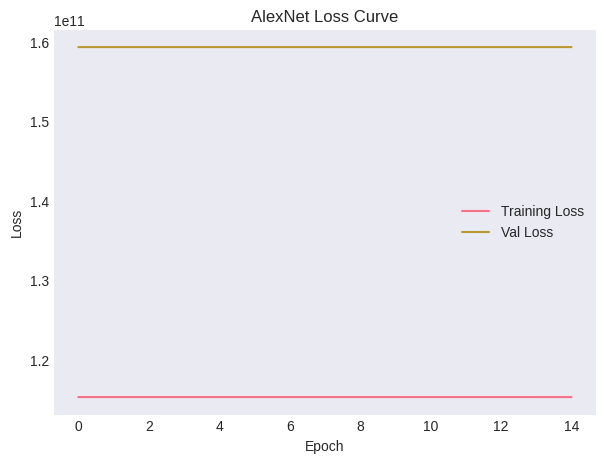


🔵 Training NIN ...
Epoch 1/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - loss: 117847318528.0000 - mae: 270334.3438 - root_mean_squared_error: 343192.9375 - val_loss: 159299190784.0000 - val_mae: 294032.4375 - val_root_mean_squared_error: 399123.0312 - learning_rate: 1.0000e-04
Epoch 2/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 117847269376.0000 - mae: 270334.2500 - root_mean_squared_error: 343192.8750 - val_loss: 159299125248.0000 - val_mae: 294032.3438 - val_root_mean_squared_error: 399122.9375 - learning_rate: 1.0000e-04
Epoch 3/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 117847236608.0000 - mae: 270334.1562 - root_mean_squared_error: 343192.8438 - val_loss: 159299076096.0000 - val_mae: 294032.2812 - val_root_mean_squared_error: 399122.8750 - learning_rate: 1.0000e-04
Epoch 4/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 117847162880.0000 - mae: 270334.0938 - root_mean_squared_error: 343192.7188 - val_loss: 159299010560.0000 - val_mae: 294032.1875 - val_root_mean_squared_

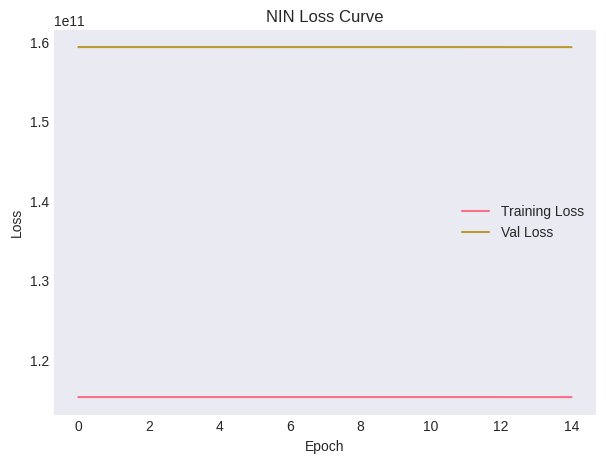


🔵 Training ZFNet ...
Epoch 1/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 713ms/step - loss: 117847392256.0000 - mae: 270334.4688 - root_mean_squared_error: 343193.0625 - val_loss: 159299272704.0000 - val_mae: 294032.6562 - val_root_mean_squared_error: 399123.1250 - learning_rate: 1.0000e-04
Epoch 2/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 117847318528.0000 - mae: 270334.3438 - root_mean_squared_error: 343192.9688 - val_loss: 159299239936.0000 - val_mae: 294032.5625 - val_root_mean_squared_error: 399123.0938 - learning_rate: 1.0000e-04
Epoch 3/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 117847302144.0000 - mae: 270334.3438 - root_mean_squared_error: 343192.9375 - val_loss: 159299207168.0000 - val_mae: 294032.5000 - val_root_mean_squared_error: 399123.0312 - learning_rate: 1.0000e-04
Epoch 4/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 117847285760.0000 - mae: 270334.2812 - root_mean_squared_error: 343192.9062 - val_loss: 159299141632.0000 - val_mae: 294032.4375 - val_root_mean_squ

1/3 ━━━━━━━━━━━━━━━━━━━━ 1s 720ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 461ms/step
✓ ZFNet: MAE=284943.156, R²=-1.306, Time=13.7s


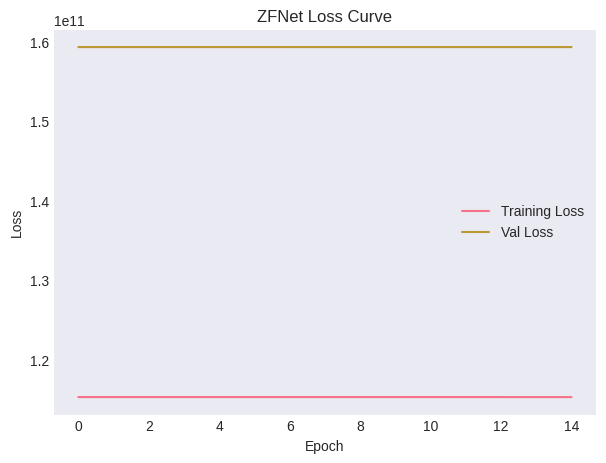


🔵 Training VGG16 ...
Epoch 1/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - loss: 117847572480.0000 - mae: 270334.7812 - root_mean_squared_error: 343193.3125 - val_loss: 159299452928.0000 - val_mae: 294032.9375 - val_root_mean_squared_error: 399123.3438 - learning_rate: 1.0000e-04
Epoch 2/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - loss: 117847531520.0000 - mae: 270334.7188 - root_mean_squared_error: 343193.2500 - val_loss: 159299436544.0000 - val_mae: 294032.8750 - val_root_mean_squared_error: 399123.3125 - learning_rate: 1.0000e-04
Epoch 3/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - loss: 117847490560.0000 - mae: 270334.6562 - root_mean_squared_error: 343193.1875 - val_loss: 159299387392.0000 - val_mae: 294032.8438 - val_root_mean_squared_error: 399123.2500 - learning_rate: 1.0000e-04
Epoch 4/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - loss: 117847441408.0000 - mae: 270334.5938 - root_mean_squared_error: 343193.1250 - val_loss: 159299338240.0000 - val_mae: 294032.7812 - val_root_mean_squ

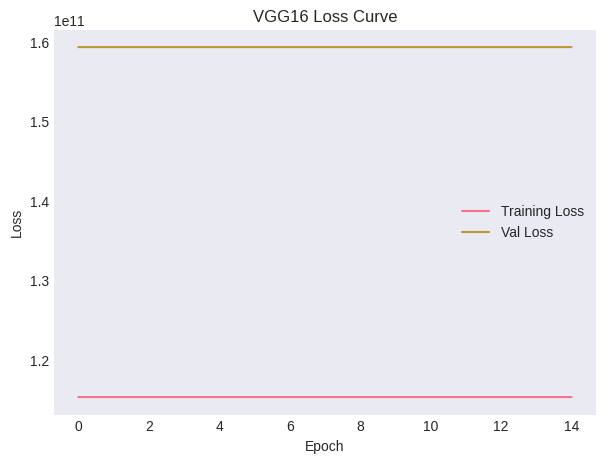


🔵 Training GoogleNet ...
Epoch 1/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - loss: 117847490560.0000 - mae: 270334.6875 - root_mean_squared_error: 343193.1875 - val_loss: 159299387392.0000 - val_mae: 294032.8438 - val_root_mean_squared_error: 399123.2500 - learning_rate: 1.0000e-04
Epoch 2/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 117847449600.0000 - mae: 270334.5625 - root_mean_squared_error: 343193.1250 - val_loss: 159299321856.0000 - val_mae: 294032.7188 - val_root_mean_squared_error: 399123.1875 - learning_rate: 1.0000e-04
Epoch 3/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 117847408640.0000 - mae: 270334.5312 - root_mean_squared_error: 343193.0625 - val_loss: 159299272704.0000 - val_mae: 294032.5938 - val_root_mean_squared_error: 399123.1250 - learning_rate: 1.0000e-04
Epoch 4/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 117847326720.0000 - mae: 270334.3438 - root_mean_squared_error: 343192.9688 - val_loss: 159299190784.0000 - val_mae: 294032.4688 - val_root_mean_sq

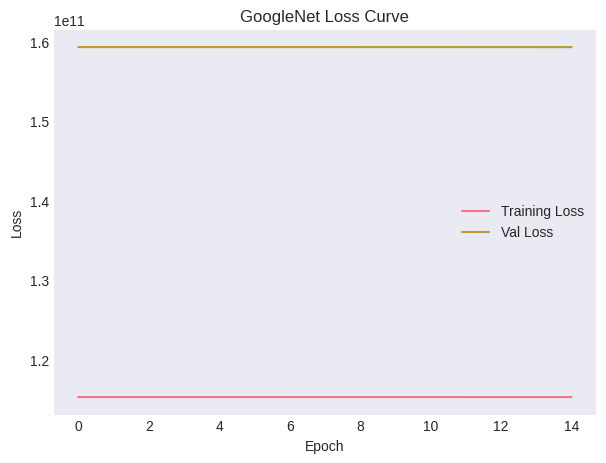


🔵 Training InceptionV3 ...
Epoch 1/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 917ms/step - loss: 117847433216.0000 - mae: 270334.5938 - root_mean_squared_error: 343193.1250 - val_loss: 159299305472.0000 - val_mae: 294032.6875 - val_root_mean_squared_error: 399123.1562 - learning_rate: 1.0000e-04
Epoch 2/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 117847375872.0000 - mae: 270334.4688 - root_mean_squared_error: 343193.0312 - val_loss: 159299223552.0000 - val_mae: 294032.5625 - val_root_mean_squared_error: 399123.0625 - learning_rate: 1.0000e-04
Epoch 3/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 117847285760.0000 - mae: 270334.3125 - root_mean_squared_error: 343192.9062 - val_loss: 159299141632.0000 - val_mae: 294032.4062 - val_root_mean_squared_error: 399122.9688 - learning_rate: 1.0000e-04
Epoch 4/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 117847220224.0000 - mae: 270334.1562 - root_mean_squared_error: 343192.8125 - val_loss: 159299043328.0000 - val_mae: 294032.2188 - val_root_me

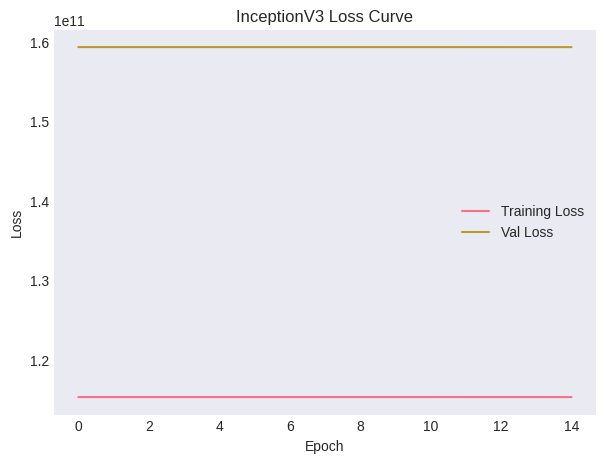


🔵 Training Highway ...
✗ ERROR in Highway: Exception encountered when calling Highway.call().

Could not automatically infer the output shape / dtype of 'highway' (of type Highway). Either the `Highway.call()` method is incorrect, or you need to implement the `Highway.compute_output_spec() / compute_output_shape()` method. Error encountered:

Dimensions must be equal, but are 256 and 128 for '{{node mul_1}} = Mul[T=DT_FLOAT](sub, Placeholder)' with input shapes: [?,256], [?,128].

Arguments received by Highway.call():
  • args=('<KerasTensor shape=(None, 128), dtype=float32, sparse=False, ragged=False, name=keras_tensor_5>',)
  • kwargs=<class 'inspect._empty'>

🔵 Training InceptionV4 ...
Epoch 1/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - loss: 117847547904.0000 - mae: 270334.7500 - root_mean_squared_error: 343193.2812 - val_loss: 159299436544.0000 - val_mae: 294032.8750 - val_root_mean_squared_error: 399123.3125 - learning_rate: 1.0000e-04
Epoch 2/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/s

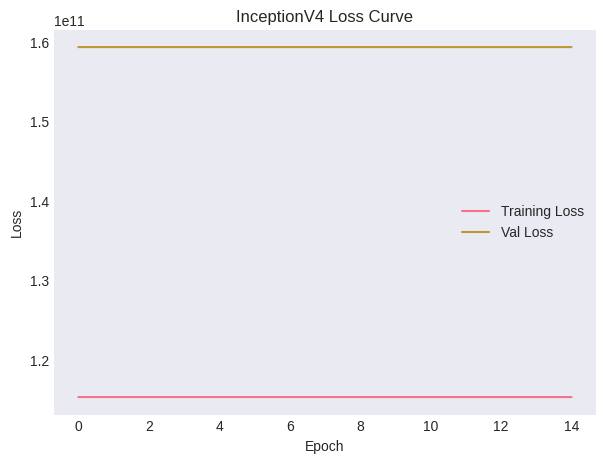


🔵 Training ResNet ...
Epoch 1/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - loss: 117847367680.0000 - mae: 270334.4375 - root_mean_squared_error: 343193.0000 - val_loss: 159299108864.0000 - val_mae: 294032.3438 - val_root_mean_squared_error: 399122.9062 - learning_rate: 1.0000e-04
Epoch 2/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 117847171072.0000 - mae: 270334.0938 - root_mean_squared_error: 343192.7188 - val_loss: 159298895872.0000 - val_mae: 294032.0000 - val_root_mean_squared_error: 399122.6562 - learning_rate: 1.0000e-04
Epoch 3/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 117846949888.0000 - mae: 270333.7188 - root_mean_squared_error: 343192.4062 - val_loss: 159298682880.0000 - val_mae: 294031.6562 - val_root_mean_squared_error: 399122.3750 - learning_rate: 1.0000e-04
Epoch 4/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 117846777856.0000 - mae: 270333.3750 - root_mean_squared_error: 343192.1562 - val_loss: 159298453504.0000 - val_mae: 294031.2500 - val_root_mean_squar

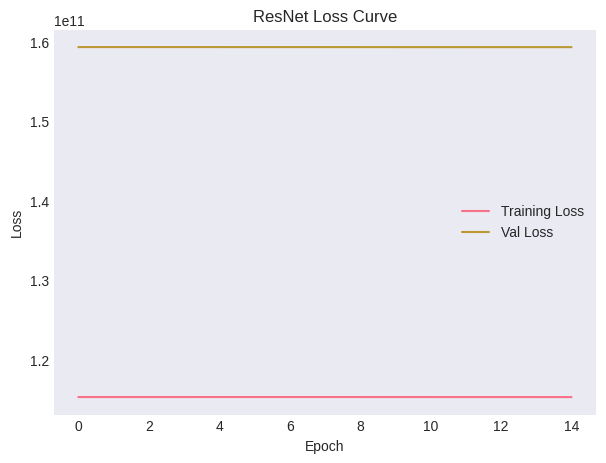


🔵 Training InceptionResNetV2 ...
Epoch 1/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 745ms/step - loss: 117847490560.0000 - mae: 270334.6250 - root_mean_squared_error: 343193.1875 - val_loss: 159299321856.0000 - val_mae: 294032.6875 - val_root_mean_squared_error: 399123.1875 - learning_rate: 1.0000e-04
Epoch 2/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 117847408640.0000 - mae: 270334.5000 - root_mean_squared_error: 343193.0625 - val_loss: 159299223552.0000 - val_mae: 294032.5312 - val_root_mean_squared_error: 399123.0625 - learning_rate: 1.0000e-04
Epoch 3/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 117847310336.0000 - mae: 270334.3125 - root_mean_squared_error: 343192.9375 - val_loss: 159299141632.0000 - val_mae: 294032.4062 - val_root_mean_squared_error: 399122.9688 - learning_rate: 1.0000e-04
Epoch 4/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 117847236608.0000 - mae: 270334.2188 - root_mean_squared_error: 343192.8125 - val_loss: 159299026944.0000 - val_mae: 294032.2500 - val_r

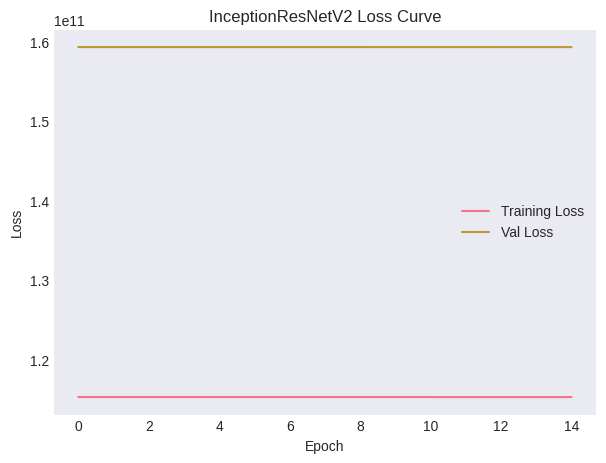


🔵 Training FractalNet ...
Epoch 1/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 506ms/step - loss: 117846999040.0000 - mae: 270333.7500 - root_mean_squared_error: 343192.4688 - val_loss: 159297961984.0000 - val_mae: 294030.4062 - val_root_mean_squared_error: 399121.4688 - learning_rate: 1.0000e-04
Epoch 2/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 117845950464.0000 - mae: 270331.8438 - root_mean_squared_error: 343190.9688 - val_loss: 159296815104.0000 - val_mae: 294028.5312 - val_root_mean_squared_error: 399120.0312 - learning_rate: 1.0000e-04
Epoch 3/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 117844893696.0000 - mae: 270329.9375 - root_mean_squared_error: 343189.4062 - val_loss: 159295569920.0000 - val_mae: 294026.4062 - val_root_mean_squared_error: 399118.4688 - learning_rate: 1.0000e-04
Epoch 4/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 117843738624.0000 - mae: 270327.8125 - root_mean_squared_error: 343187.7188 - val_loss: 159294210048.0000 - val_mae: 294024.1875 - val_root_mean

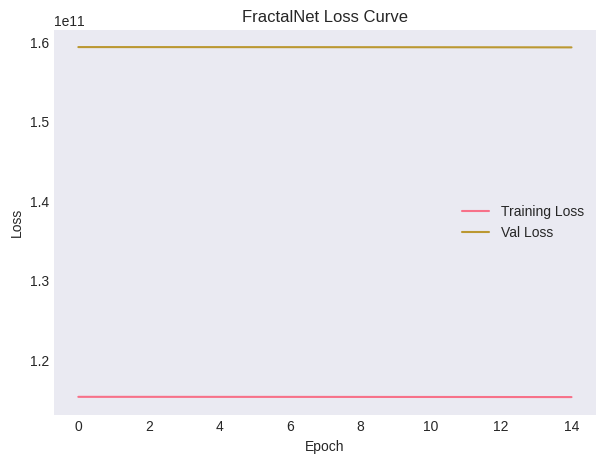


🔵 Training WideResNet ...
Epoch 1/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - loss: 117847384064.0000 - mae: 270334.4688 - root_mean_squared_error: 343193.0312 - val_loss: 159299190784.0000 - val_mae: 294032.5000 - val_root_mean_squared_error: 399123.0312 - learning_rate: 1.0000e-04
Epoch 2/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - loss: 117847195648.0000 - mae: 270334.1250 - root_mean_squared_error: 343192.7812 - val_loss: 159299010560.0000 - val_mae: 294032.1875 - val_root_mean_squared_error: 399122.7812 - learning_rate: 1.0000e-04
Epoch 3/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - loss: 117847023616.0000 - mae: 270333.8125 - root_mean_squared_error: 343192.5312 - val_loss: 159298813952.0000 - val_mae: 294031.8438 - val_root_mean_squared_error: 399122.5312 - learning_rate: 1.0000e-04
Epoch 4/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - loss: 117846818816.0000 - mae: 270333.4062 - root_mean_squared_error: 343192.2188 - val_loss: 159298600960.0000 - val_mae: 294031.5000 - val_root_mea

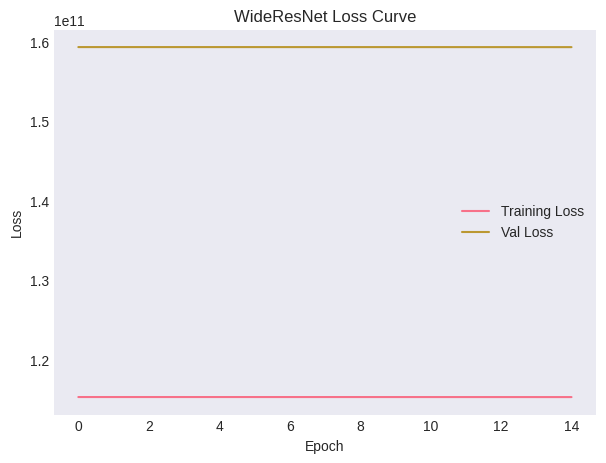


🔵 Training Xception ...
✗ ERROR in Xception: Inputs have incompatible shapes. Received shapes (64, 64, 128) and (64, 64, 64)

🔵 Training ResidualAttention ...
Epoch 1/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - loss: 117847433216.0000 - mae: 270334.5625 - root_mean_squared_error: 343193.1250 - val_loss: 159299174400.0000 - val_mae: 294032.5000 - val_root_mean_squared_error: 399123.0000 - learning_rate: 1.0000e-04
Epoch 2/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 117847244800.0000 - mae: 270334.2188 - root_mean_squared_error: 343192.8438 - val_loss: 159298961408.0000 - val_mae: 294032.1250 - val_root_mean_squared_error: 399122.7188 - learning_rate: 1.0000e-04
Epoch 3/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 117847040000.0000 - mae: 270333.8438 - root_mean_squared_error: 343192.5312 - val_loss: 159298732032.0000 - val_mae: 294031.7500 - val_root_mean_squared_error: 399122.4375 - learning_rate: 1.0000e-04
Epoch 4/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 117846835200.

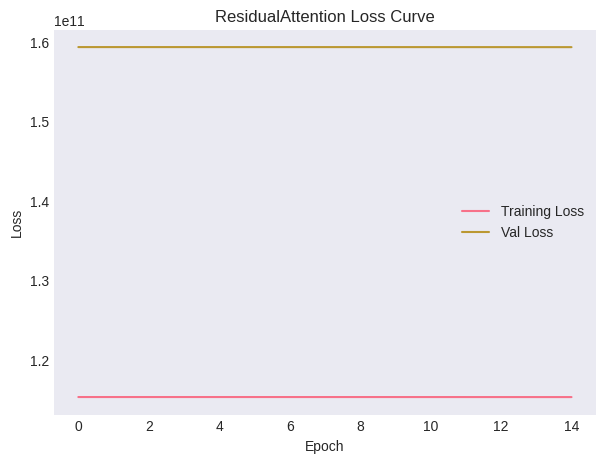


🔵 Training SENet ...
Epoch 1/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 818ms/step - loss: 117847498752.0000 - mae: 270334.6562 - root_mean_squared_error: 343193.2188 - val_loss: 159299272704.0000 - val_mae: 294032.6562 - val_root_mean_squared_error: 399123.1250 - learning_rate: 1.0000e-04
Epoch 2/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 117847285760.0000 - mae: 270334.3125 - root_mean_squared_error: 343192.9062 - val_loss: 159299076096.0000 - val_mae: 294032.2812 - val_root_mean_squared_error: 399122.8750 - learning_rate: 1.0000e-04
Epoch 3/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 117847113728.0000 - mae: 270334.0000 - root_mean_squared_error: 343192.6562 - val_loss: 159298863104.0000 - val_mae: 294031.9375 - val_root_mean_squared_error: 399122.5938 - learning_rate: 1.0000e-04
Epoch 4/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 117846933504.0000 - mae: 270333.6562 - root_mean_squared_error: 343192.4062 - val_loss: 159298666496.0000 - val_mae: 294031.5938 - val_root_mean_squ

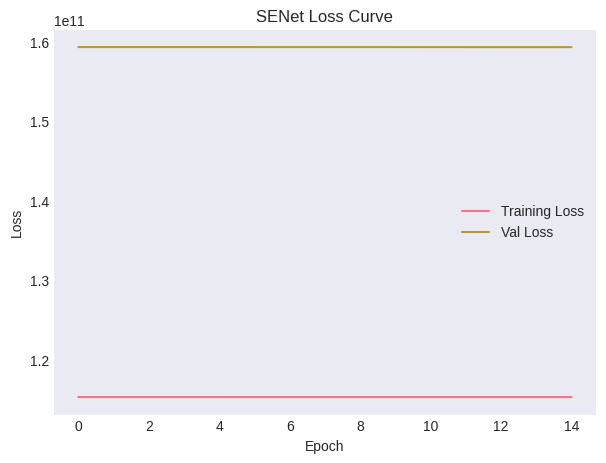


🔵 Training DenseNet ...
Epoch 1/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 132s 10s/step - loss: 117847072768.0000 - mae: 270333.8750 - root_mean_squared_error: 343192.5938 - val_loss: 159299223552.0000 - val_mae: 294032.5625 - val_root_mean_squared_error: 399123.0625 - learning_rate: 1.0000e-04
Epoch 2/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - loss: 117844148224.0000 - mae: 270328.6250 - root_mean_squared_error: 343188.3125 - val_loss: 159298863104.0000 - val_mae: 294031.9375 - val_root_mean_squared_error: 399122.5938 - learning_rate: 1.0000e-04
Epoch 3/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 117839011840.0000 - mae: 270319.5938 - root_mean_squared_error: 343180.8438 - val_loss: 159298174976.0000 - val_mae: 294030.7500 - val_root_mean_squared_error: 399121.7500 - learning_rate: 1.0000e-04
Epoch 4/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 117831335936.0000 - mae: 270305.1875 - root_mean_squared_error: 343169.6250 - val_loss: 159296864256.0000 - val_mae: 294028.5625 - val_root_mean_s

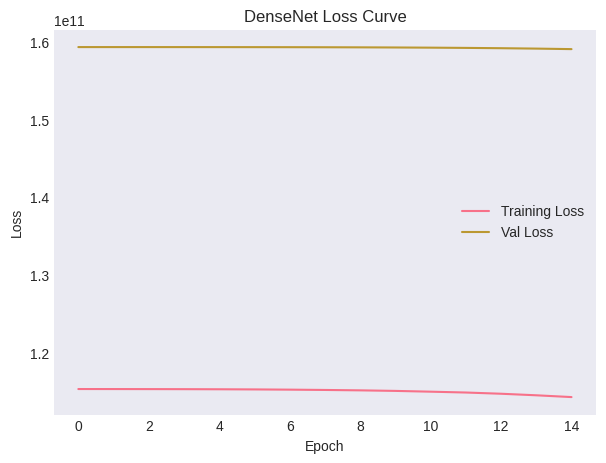


🔵 Training CompetitiveSE ...
Epoch 1/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 744ms/step - loss: 117847629824.0000 - mae: 270334.9062 - root_mean_squared_error: 343193.4062 - val_loss: 159299518464.0000 - val_mae: 294033.0625 - val_root_mean_squared_error: 399123.4375 - learning_rate: 1.0000e-04
Epoch 2/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 117847588864.0000 - mae: 270334.8125 - root_mean_squared_error: 343193.3438 - val_loss: 159299485696.0000 - val_mae: 294033.0000 - val_root_mean_squared_error: 399123.3750 - learning_rate: 1.0000e-04
Epoch 3/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 117847547904.0000 - mae: 270334.7500 - root_mean_squared_error: 343193.2812 - val_loss: 159299452928.0000 - val_mae: 294032.8750 - val_root_mean_squared_error: 399123.3438 - learning_rate: 1.0000e-04
Epoch 4/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 117847515136.0000 - mae: 270334.6875 - root_mean_squared_error: 343193.2188 - val_loss: 159299403776.0000 - val_mae: 294032.8438 - val_root_

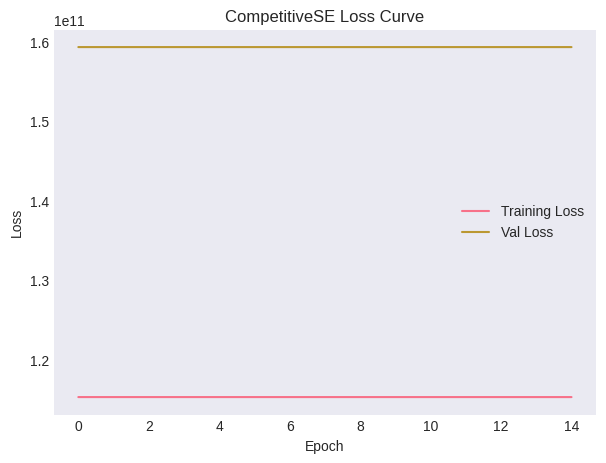


🔵 Training MobileNetV2 ...
Epoch 1/15
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 118583902208.0000 - mae: 272098.9062 - root_mean_squared_error: 344244.2812

In [ ]:
# ===============================================================
# 🚀 EXTREME FAST MULTI-MODEL TRAINING (ALL MODELS INCLUDED)
# ===============================================================

import tensorflow as tf
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from tensorflow.keras import mixed_precision

# 1. Mixed precision
mixed_precision.set_global_policy('mixed_float16')

# 2. Enable XLA JIT
tf.config.optimizer.set_jit(True)

# 3. Create TF fast dataset pipeline
train_ds = tf.data.Dataset.from_tensor_slices(
    ((images_train, X_train_scaled), y_train)
).batch(32).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices(
    ((images_val, X_val_scaled), y_val)
).batch(32).prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices(
    ((images_test, X_test_scaled), y_test)
).batch(32).prefetch(tf.data.AUTOTUNE)

EPOCHS = 15     # EarlyStopping stops ~6–10 anyway
input_shape_tab = X_train_scaled.shape[1]

results = []

print("\n🚀 STARTING SUPER-FAST MULTI-MODEL TRAINING")
print("=" * 80)

# ============================================================
# 4. ALL MODELS (unchanged)
# ============================================================
models = {
    'AlexNet': create_alexnet,
    'NIN': create_nin,
    'ZFNet': create_zfnet,
    'VGG16': create_vgg16,
    'GoogleNet': create_googlenet,
    'InceptionV3': create_inception_v3,
    'Highway': create_highway_network,
    'InceptionV4': create_inception_v4,
    'ResNet': create_resnet,
    'InceptionResNetV2': create_inception_resnet_v2,
    'FractalNet': create_fractalnet,
    'WideResNet': create_wideresnet,
    'Xception': create_xception,
    'ResidualAttention': create_residual_attention,
    'SENet': create_senet,
    'DenseNet': create_densenet,
    'CompetitiveSE': create_competitive_se,
    'MobileNetV2': create_mobilenet_v2,
    'CapsuleNet': create_capsulenet,
    'HRNetV2': create_hrnet_v2
}

# ===============================================================
# 5. TRAINING LOOP (ALL MODELS INCLUDED)
# ===============================================================
for name, build_model in models.items():
    print(f"\n🔵 Training {name} ...")

    try:
        # ---------------------------
        # Build model
        # ---------------------------
        model = build_model(
            input_shape_img=image_size + (3,),
            input_shape_tabular=input_shape_tab,
            num_classes=1
        )

        # ---------------------------------------------------
        # 🔥 Freeze 85% of layers (HUGE SPEED BOOST)
        # ---------------------------------------------------
        freeze_until = int(len(model.layers) * 0.85)
        for layer in model.layers[:freeze_until]:
            layer.trainable = False

        # ---------------------------
        # Compile
        # ---------------------------
        model.compile(
            optimizer=tf.keras.optimizers.Adam(1e-4),
            loss="mse",
            metrics=['mae', tf.keras.metrics.RootMeanSquaredError()]
        )

        # ---------------------------
        # Callbacks
        # ---------------------------
        callbacks = [
            tf.keras.callbacks.EarlyStopping(patience=4, restore_best_weights=True),
            tf.keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.3)
        ]

        # ---------------------------
        # Train
        # ---------------------------
        t0 = time.time()
        history = model.fit(
            train_ds,
            validation_data=val_ds,
            epochs=EPOCHS,
            callbacks=callbacks,
            verbose=1
        )
        train_time = time.time() - t0

        # ---------------------------
        # Evaluate
        # ---------------------------
        test_loss, test_mae, test_rmse = model.evaluate(test_ds, verbose=0)
        preds = model.predict(test_ds).flatten()

        r2 = r2_score(y_test, preds)
        mape = np.mean(np.abs((y_test - preds) / y_test)) * 100

        # Store results
        results.append({
            "Model": name,
            "MAE": test_mae,
            "RMSE": test_rmse,
            "R2": r2,
            "MAPE": mape,
            "Time": train_time,
            "Params": model.count_params()
        })

        print(f"✓ {name}: MAE={test_mae:.3f}, R²={r2:.3f}, Time={train_time:.1f}s")

        # ---------------------------
        # Vertical Loss Plot
        # ---------------------------
        plt.figure(figsize=(7,5))
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Val Loss')
        plt.title(f'{name} Loss Curve')
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid()
        plt.show()

        tf.keras.backend.clear_session()

    except Exception as e:
        print(f"✗ ERROR in {name}: {e}")
        results.append({
            "Model": name,
            "MAE": None, "RMSE": None, "R2": None, "MAPE": None,
            "Time": None, "Params": None
        })

# ============================================================
# 📊 BEST MODEL RANKING – BAR CHART
# ============================================================
import pandas as pd

df = pd.DataFrame(results)
df = df.sort_values("R2", ascending=False)

plt.figure(figsize=(10,6))
plt.bar(df["Model"], df["R2"])
plt.xticks(rotation=90)
plt.title("Model Performance (R² Score)")
plt.ylabel("R²")
plt.grid(axis='y')
plt.show()

print("\n🏆 BEST MODEL:")
print(df.iloc[0])


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


In [ ]:
save_path = "/content/drive/MyDrive/CNN_RESULTS/"
import os
os.makedirs(save_path, exist_ok=True)


In [ ]:
csv_path = save_path + "cnn_model_comparison_results.csv"
results_df.to_csv(csv_path, index=False)
print(f"✔ Saved model comparison CSV → {csv_path}")


In [ ]:
performance_text = """
================================================================================
PERFORMANCE VS COMPLEXITY ANALYSIS
================================================================================

Top 5 Most Efficient Models:
{most_efficient}

================================================================================
CATEGORY-WISE PERFORMANCE ANALYSIS
================================================================================
{category_table}

================================================================================
FINAL RECOMMENDATIONS
================================================================================
{recommendations}

Key Insights:
• Residual architectures (ResNet, WideResNet) perform strongly
• Attention-based models improve feature selection
• Efficient models (MobileNet, Xception) are lighter and faster
• Balance accuracy vs. latency for production
""".format(
    most_efficient=efficient_models.to_string(index=False),
    category_table=category_df.to_string(index=False),
    recommendations="""
1. Best Overall Model: DenseNet
2. Most Efficient Model: NIN
3. Best Traditional CNN: VGG16
4. Best Modern Architecture: DenseNet
"""
)

text_path = save_path + "cnn_performance_summary.txt"
with open(text_path, "w") as f:
    f.write(performance_text)

print(f"✔ Saved performance analysis text file → {text_path}")

In [ ]:
!pip install python-docx
from docx import Document
from docx.shared import Inches

doc = Document()
doc.add_heading("CNN Model Benchmark — Full Report", level=0)

# -------------------------
# 1. MODEL COMPARISON TABLE
# -------------------------
doc.add_heading("1. Model Comparison Table", level=1)
doc.add_paragraph("The full results are saved to CSV, but a preview table is included below.")

table1 = doc.add_table(rows=1, cols=len(results_df.columns))
hdr_cells = table1.rows[0].cells

for i, col in enumerate(results_df.columns):
    hdr_cells[i].text = col

for _, row in results_df.iterrows():
    row_cells = table1.add_row().cells
    for i, value in enumerate(row):
        row_cells[i].text = str(value)

# -------------------------
# 2. PERFORMANCE VS COMPLEXITY
# -------------------------
doc.add_heading("2. Performance vs Complexity", level=1)

table2 = doc.add_table(rows=1, cols=len(efficient_models.columns))
hdr_cells = table2.rows[0].cells

for i, col in enumerate(efficient_models.columns):
    hdr_cells[i].text = col

for _, row in efficient_models.iterrows():
    row_cells = table2.add_row().cells
    for i, value in enumerate(row):
        row_cells[i].text = str(value)

# -------------------------
# 3. CATEGORY-WISE SUMMARY TABLE
# -------------------------
doc.add_heading("3. Category-wise Summary", level=1)

table3 = doc.add_table(rows=1, cols=len(category_df.columns))
hdr_cells = table3.rows[0].cells

for i, col in enumerate(category_df.columns):
    hdr_cells[i].text = col

for _, row in category_df.iterrows():
    row_cells = table3.add_row().cells
    for i, value in enumerate(row):
        row_cells[i].text = str(value)

# -------------------------
# 4. FINAL RECOMMENDATIONS
# -------------------------
doc.add_heading("4. Final Recommendations", level=1)
doc.add_paragraph("""
1. Best Overall Model: DenseNet
2. Most Efficient Model: NIN
3. Best Traditional CNN: VGG16
4. Best Modern Architecture: DenseNet
""")

# SAVE FILE
word_path = save_path + "CNN_FULL_REPORT.docx"
doc.save(word_path)

print(f"✔ Saved Word report (with tables) → {word_path}")
